# MLSS final project. Safe MNIST classifier.




In [ ]:
!pip install torch torchvision foolbox opendatasets pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 63.1 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#Import Libraries


from __future__ import print_function
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from foolbox import PyTorchModel as FBModel, attacks as fbattacks, utils as fbutils, plot as fbplot, criteria as fbcriteria
import pandas as pd
import opendatasets as od
import sklearn.metrics as sk
import os
from collections import defaultdict
from PIL import Image

In [ ]:
args={}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')        

kwargs={}
args['batch_size_conv']=120
args['test_batch_size_conv']=120
args['batch_size_ood']=1
args['batch_size_outlier'] = 120
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['ensemble_epochs'] = 1
args['lr']=0.01 #Learning rate is how fast it will decend.
args['lr_conv']=0.001 #Learning rate is how fast it will decend.
args['weight_decay']=0.999 #L2 penalty
args['gamma']=0.98 #exponential decay of our learning rate
args['momentum']=0.5 
args['num_workers'] = 10
args['seed']=1 #random seed
args['log_interval']=10
args['cuda']= args['device'] == torch.device('cuda')

# Load data

In [ ]:
#download the mnist dataset for training
mnist_train = datasets.MNIST(
    '../data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        ]),
    target_transform=transforms.Compose([
                        lambda x:torch.LongTensor([x]), 
                        lambda x:F.one_hot(x,10)
                        ])
    )
mnist_train_n = len(mnist_train)
print('mnist_train_n', mnist_train_n)
train_subset, val_subset = torch.utils.data.random_split(
  mnist_train,
  [int(mnist_train_n * 5/6), int(mnist_train_n*1/6)],
  generator=torch.Generator().manual_seed(1)
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

mnist_train_n 60000


In [ ]:
od.download("https://www.kaggle.com/datasets/lubaroli/notmnist")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: emaborevkovic
Your Kaggle Key: ··········


100%|██████████| 8.07M/8.07M [00:00<00:00, 84.5MB/s]

In [ ]:
!tar -xvf /content/notmnist/notMNIST_small.tar.gz

os.remove('./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png')
os.remove('./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png')

Streaming output truncated to the last 5000 lines.
notMNIST_small/D/SVRDIEJlbmd1aWF0IEJvbGQgSXRhbGljLnBmYg==.png
notMNIST_small/D/Q2FsY3VsdXNMQ0RDYW1lby5vdGY=.png
notMNIST_small/D/QW5kcmV3QW5keUthY3R1cy50dGY=.png
notMNIST_small/D/RFRMRmxlaXNjaG1hbm4tVEJvbGRDYXBzLm90Zg==.png
notMNIST_small/D/RW5zY2hlZGUtTWVkaXVtLm90Zg==.png
notMNIST_small/D/Q2VudHVyeSBTY2hvb2xib29rIFNTaSBCb2xkIEl0YWxpYy50dGY=.png
notMNIST_small/D/RmxvdHNhbSBTdGlmZiBVcHBlci50dGY=.png
notMNIST_small/D/Q2xhc3NpY2FsR2FyYW1vbmRCVC1Sb21hbi5vdGY=.png
notMNIST_small/D/SGFuIFNvbG8udHRm.png
notMNIST_small/D/SWNvbmUgTFQgTGlnaHQgSXRhbGljIE9zRi50dGY=.png
notMNIST_small/D/Q29seW1waWEtRGVtaUJvbGQub3Rm.png
notMNIST_small/D/QXN0aWdtYSBSZWd1bGFyLnR0Zg==.png
notMNIST_small/D/Q2l0aXplbkxpZ2h0IFJlZ3VsYXIudHRm.png
notMNIST_small/D/Q2FudXRoLnR0Zg==.png
notMNIST_small/D/SHViYnViIFNTaSBCb2xkLnR0Zg==.png
notMNIST_small/D/QURNT05PLVJlZ3VsYXIudHRm.png
notMNIST_small/D/QmF0YWtDb25kZW5zZWRJVENTdGRCb2xkLm90Zg==.png
notMNIST_small/D/QWNoaWxsZXNCbHVyTG

In [ ]:
notmnist = datasets.ImageFolder('./notMNIST_small/', transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()]),
    target_transform=transforms.Compose([
        lambda x:torch.LongTensor([x]),
        lambda x:F.one_hot(x,10)
        ])  
    )

notmnist_n = len(notmnist)

val_ood, test_ood = torch.utils.data.random_split(
  notmnist,
  [int(notmnist_n * 1/2), int(notmnist_n * 1/2)],
  generator=torch.Generator().manual_seed(1)
)

ood_val_loader = torch.utils.data.DataLoader(
  val_ood,
  batch_size = args['batch_size_ood'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

ood_test_loader = torch.utils.data.DataLoader(
  test_ood,
  batch_size = args['batch_size_ood'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
fashion_train = datasets.FashionMNIST('./data',
                                     train=True, 
                                     download=True, 
                                     transform=transforms.ToTensor(), 
                                     target_transform=transforms.Compose([
                                        lambda x:torch.LongTensor([x]), # or just torch.tensor
                                        lambda x:F.one_hot(x,10)
                                        ])
                                     )
fashion_test = datasets.FashionMNIST('./data',
                                     train=False, 
                                     download=True, 
                                     transform=transforms.ToTensor(), 
                                     target_transform=transforms.Compose([
                                        lambda x:torch.LongTensor([x]), # or just torch.tensor
                                        lambda x:F.one_hot(x,10)
                                        ])
                                     )
fashion_train_n = len(fashion_train)
fashion_train_subset, fashion_val_subset = torch.utils.data.random_split(
  fashion_train,
  [int(fashion_train_n * 5/6), int(fashion_train_n*1/6)],
  generator=torch.Generator().manual_seed(1)
)
fashion_test = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

outlier_loader = torch.utils.data.DataLoader(
  fashion_train_subset,
  batch_size = args['batch_size_outlier'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

outlier_val_loader = torch.utils.data.DataLoader(
  fashion_val_subset,
  batch_size = args['batch_size_ood'], 
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

outlier_test_loader = torch.utils.data.DataLoader(
  fashion_test,
  batch_size = args['batch_size_ood'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Data Augmentation

Gaussian Noise




In [ ]:
def gaussian_noise(train_data, perc_noisy=100):
    num_noisy = len(train_data) * perc_noisy/100
    noisy_train_data = []; 
    idx = np.random.randint(0, len(train_data), int(num_noisy))      
    for i in range(len(train_data)):
      label = train_data[i][1]
      noisy_train_data.append((train_data[i][0],label))
      if i in idx:
        noise_multiplier = torch.rand(1)
        noisy_example = train_data[i][0] + noise_multiplier/2 * torch.randn(28,28)
        noisy_train_data.append((noisy_example,label))
    return noisy_train_data

In [ ]:
mnist_train_noise_10 = gaussian_noise(mnist_train, perc_noisy = 10)

In [ ]:
mnist_train_noise_15 = gaussian_noise(mnist_train, perc_noisy = 15)

In [ ]:
mnist_train_noise_20 = gaussian_noise(mnist_train, perc_noisy = 20)

In [ ]:
mnist_train_noise_25 = gaussian_noise(mnist_train, perc_noisy = 25)

In [ ]:
mnist_train_noise_30 = gaussian_noise(mnist_train, perc_noisy = 30)

In [ ]:
len(mnist_train_noise_10)


65703

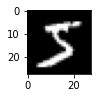

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


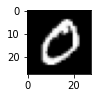

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


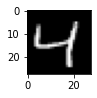

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


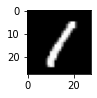

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


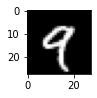

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


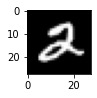

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


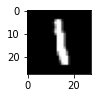

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


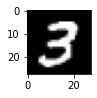

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


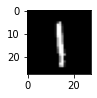

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
for i in range(9):  
  plt.subplot(330 + 1 + i)  
  plt.imshow(mnist_train_noise_10[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_noise_10[i][1])

Rotation (and Gaussian Noise)

In [ ]:
def random_rotation(train_data, perc_rotated=100, randomNoise=False):
    num_rotated = len(train_data) * perc_rotated/100
    rotated_train_data = []; 
    rotater = T.RandomRotation(degrees=(0, 180))
    idx = np.random.randint(0, len(train_data), int(num_rotated))  

    for i in range(len(train_data)):
      label = train_data[i][1]
      rotated_train_data.append((train_data[i][0],label))
      if i in idx:
        rotated_example = rotater(train_data[i][0])
        if randomNoise:
          noise_multiplier = torch.rand(1)
          rotated_example = rotated_example + noise_multiplier/2 * torch.randn(28,28)
          label = train_data[i][1]
        rotated_train_data.append((rotated_example,label))
    return rotated_train_data

In [ ]:
mnist_train_rot_10 = random_rotation(mnist_train, perc_rotated = 10, randomNoise=True)

In [ ]:
mnist_train_rot_15 = random_rotation(mnist_train, perc_rotated = 15, randomNoise=True)

In [ ]:
mnist_train_rot_20 = random_rotation(mnist_train, perc_rotated = 20, randomNoise=True)

In [ ]:
mnist_train_rot_25 = random_rotation(mnist_train, perc_rotated = 25, randomNoise=True)

In [ ]:
mnist_train_rot_30 = random_rotation(mnist_train, perc_rotated = 30, randomNoise=True)

In [ ]:
len(mnist_train_rot_10)

65706

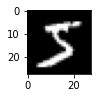

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


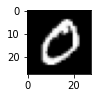

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


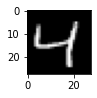

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


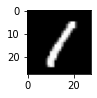

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


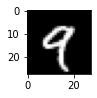

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


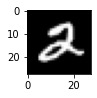

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


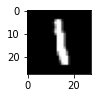

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


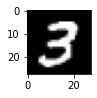

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


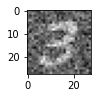

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [ ]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(mnist_train_rot_10[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_rot_10[i][1])

Flipping

In [ ]:
def flipping(train_data):
  
  p_h = torch.randn(1)
  hflipper = T.RandomHorizontalFlip(p_h)
  p_v = torch.randn(1)
  vflipper = T.RandomVerticalFlip(p_v)

  flipped_train_data = []

  for i in range(len(train_data)):
    flipped_train_data.append((train_data[i][0], train_data[i][1]))
    flipped_1 = hflipper(train_data[i][0])
    flipped_2 = vflipper(flipped_1)
    label = train_data[i][1]
    if torch.equal(flipped_2, train_data[i][0]):
      continue
    else:  
      flipped_train_data.append((flipped_2, label))
  return flipped_train_data


In [ ]:
mnist_train_dataug_flip = flipping(mnist_train)

In [ ]:
len(mnist_train_dataug_flip)

96398

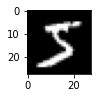

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


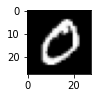

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


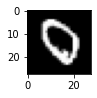

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


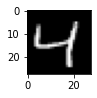

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


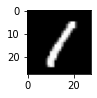

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


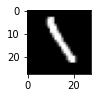

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


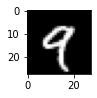

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


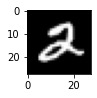

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


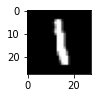

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(mnist_train_dataug_flip[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_dataug_flip[i][1])

Inversion

In [ ]:
def inversion(train_data, perc_inverted=100):
  
  inverter = T.RandomInvert()
  inverted_train_data = []
  num_inv = len(train_data) * perc_inverted/100
  idx = np.random.randint(0, len(train_data), int(num_inv))  
  for i in range(len(train_data)):
    inverted_train_data.append((train_data[i][0],train_data[i][1]))
    if i in idx:
      inverted_img = inverter(train_data[i][0]) 
      label = train_data[i][1]
      inverted_train_data.append((inverted_img, label))
  return inverted_train_data



In [ ]:
mnist_train_inverted = inversion(mnist_train, perc_inverted=10)

In [ ]:
len(mnist_train_inverted)

65696

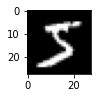

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


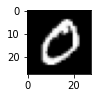

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


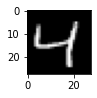

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


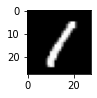

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


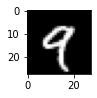

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


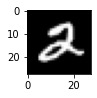

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


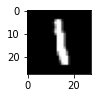

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


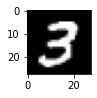

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


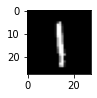

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(mnist_train_inverted[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_inverted[i][1])

MixUp

In [ ]:
def mixup(train_data, perc_mixed=100):
    
    num_mixed = len(train_data) * perc_mixed/100
    #images = []; labels = [];
    mixup_data=[];
    idx_list = np.random.randint(0, len(train_data), int(num_mixed))  
    for idx in range(len(train_data)):
      mixup_data.append((train_data[idx][0], train_data[idx][1]))
      if idx in idx_list:

          image = train_data[idx][0]
          label = train_data[idx][1]
          
          # Choose another image/label randomly
          mixup_idx = np.random.randint(0, len(train_data))
          mixup_image = train_data[mixup_idx][0]
          mixup_label = train_data[mixup_idx][1]
          # Select a random number from the given beta distribution
          # Mixup the images accordingly
          alpha = 0.2
          lam = np.random.beta(alpha, alpha)
          image = lam * image + (1 - lam) * mixup_image
          label = lam * label + (1 - lam) * mixup_label
          
          #images.append(image)
          #labels.append(label)
          mixup_data.append((image,label))
    return mixup_data

In [ ]:
mnist_train_mixup_10 = mixup(mnist_train, 10)

In [ ]:
mnist_train_mixup_15 = mixup(mnist_train, 15)

In [ ]:
mnist_train_mixup_20 = mixup(mnist_train, 20)

In [ ]:
mnist_train_mixup_25 = mixup(mnist_train, 25)

In [ ]:
mnist_train_mixup_30 = mixup(mnist_train, 30)

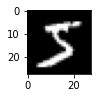

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


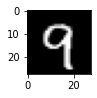

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5498e-08,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])


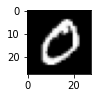

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


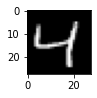

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


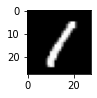

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


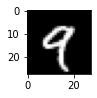

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


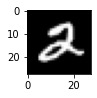

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


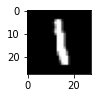

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


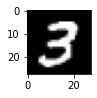

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(mnist_train_mixup_10[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_mixup_10[i][1])

CutMix

In [ ]:
def rand_bbox(size, lam):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_ratio = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_ratio)
    cut_h = np.int(H * cut_ratio)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [ ]:
mnist_train_list = []
for i in range(len(mnist_train)):
  mnist_train_list.append(list(mnist_train[i]))

def generate_cutmix_image(train_data, perc_cutmix=100, beta=1.0):

    cutmix_examples = []
    num_cutmixed = len(train_data) * perc_cutmix/100
    idx_list = np.random.randint(0, len(train_data), int(num_cutmixed))  

    for idx in range(len(train_data)):
      cutmix_examples.append((train_data[idx][0],train_data[idx][1]))
      if idx in idx_list:
        lam = np.random.beta(beta, beta)
        idx_a = idx
        idx_b = np.random.randint(len(train_data))
        img_a = train_data[idx_a][0]
        img_b = train_data[idx_b][0]
        target_a = train_data[idx_a][1]
        target_b = train_data[idx_b][1]
        bbx1, bby1, bbx2, bby2 = rand_bbox(train_data[idx_a][0].squeeze(0).shape, lam)
        #train_data_updated = train_data.copy()
        train_data_updated = train_data.copy()

        img_a_box = img_a[bbx1:bbx2, bby1:bby2]
        img_b_box = img_b[bbx1:bbx2, bby1:bby2]
        img_a[bbx1:bbx2, bby1:bby2] = img_b_box
        img_b[bbx1:bbx2, bby1:bby2] = img_a_box
        train_data_updated[idx_a][0] = img_a
        train_data_updated[idx_b][0] = img_b

      # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (28 * 28))
        label = target_a * lam + target_b * (1. - lam)
        cutmix_examples.append((train_data_updated[idx_a][0],label))
    return cutmix_examples
    #return train_data_updated, labels



In [ ]:
# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
mnist_train_cutmix_10 = generate_cutmix_image(mnist_train_list, perc_cutmix=10, beta=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

In [ ]:
mnist_train_cutmix_15 = generate_cutmix_image(mnist_train_list, perc_cutmix=15, beta=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

In [ ]:
mnist_train_cutmix_20 = generate_cutmix_image(mnist_train_list, perc_cutmix=20, beta=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

In [ ]:
mnist_train_cutmix_25 = generate_cutmix_image(mnist_train_list, perc_cutmix=25, beta=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

In [ ]:
mnist_train_cutmix_30 = generate_cutmix_image(mnist_train_list, perc_cutmix=30, beta=1.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

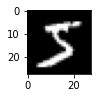

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


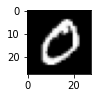

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


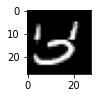

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])


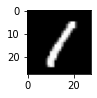

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


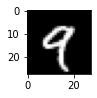

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


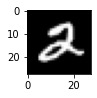

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])


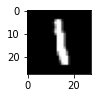

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


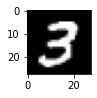

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])


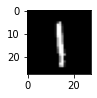

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])


In [ ]:
# Show CutMix images

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(mnist_train_cutmix_10[i][0].squeeze(0), cmap=plt.get_cmap('gray'))
  plt.show()
  print(mnist_train_cutmix_10[i][1])


# CNN ensemble

In this section we will implement three convolutional neural networks and combine them in an ensemble as in this paper: https://arxiv.org/pdf/2008.10400v2.pdf

In [ ]:
# load the data with validation set for conv ensemble

train_loader = torch.utils.data.DataLoader(
  train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

val_loader = torch.utils.data.DataLoader(
  val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]),
                   target_transform=transforms.Compose([
                        lambda x:torch.LongTensor([x]), # or just torch.tensor
                        lambda x:F.one_hot(x,10)
                        ])),
    batch_size=args['test_batch_size_conv'], shuffle=True, **kwargs)

## Architecture

In [ ]:
#as in the paper, except GELU instead of RELU
class conv3(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(32),
            nn.GELU(), 

            nn.Conv2d(32, 48, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(48),
            nn.GELU(), 

            nn.Conv2d(48, 64, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(64, 80, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(80),
            nn.GELU(),

            nn.Conv2d(80, 96, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(96),
            nn.GELU(),

            nn.Conv2d(96, 112, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(112),
            nn.GELU(),

            nn.Conv2d(112, 128, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(128),
            nn.GELU(),

            nn.Conv2d(128, 144, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(144),
            nn.GELU(),

            nn.Conv2d(144, 160, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(160),
            nn.GELU(),

            nn.Conv2d(160, 176, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(176),
            nn.GELU(),

            nn.Flatten(1, -1),
            nn.Linear(11264, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
class conv3_relu(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 48, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(48),
            nn.ReLU(), 

            nn.Conv2d(48, 64, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 80, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(80),
            nn.ReLU(),

            nn.Conv2d(80, 96, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.Conv2d(96, 112, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(112),
            nn.ReLU(),

            nn.Conv2d(112, 128, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 144, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(144),
            nn.ReLU(),

            nn.Conv2d(144, 160, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(160),
            nn.ReLU(),

            nn.Conv2d(160, 176, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(176),
            nn.ReLU(),

            nn.Flatten(1, -1),
            nn.Linear(11264, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
#trains faster, still 99% acc in first epoch!
class conv3_(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(32),
            nn.GELU(), 

            nn.Conv2d(32, 48, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(48),
            nn.GELU(), 

            nn.Conv2d(48, 64, kernel_size = 3, device=args['device']),
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Flatten(1, -1),
            nn.Linear(30976, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
class conv5_relu(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(32),
            nn.ReLU(), 

            nn.Conv2d(32, 64, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(64),
            nn.ReLU(), 

            nn.Conv2d(64, 96, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.Conv2d(96, 128, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 160, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(160),
            nn.ReLU(),

            nn.Flatten(1, -1),
            nn.Linear(10240, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
#as in the paper except for GELU
class conv5(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(32),
            nn.GELU(), 

            nn.Conv2d(32, 64, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(64),
            nn.GELU(), 

            nn.Conv2d(64, 96, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(96),
            nn.GELU(),

            nn.Conv2d(96, 128, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(128),
            nn.GELU(),

            nn.Conv2d(128, 160, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(160),
            nn.GELU(),

            nn.Flatten(1, -1),
            nn.Linear(10240, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
#only first three layers from the paper to train faster
class conv5_(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 32, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(32),
            nn.GELU(), 

            nn.Conv2d(32, 64, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(64),
            nn.GELU(), 

            nn.Conv2d(64, 96, kernel_size = 5, device=args['device']),
            nn.BatchNorm2d(96),
            nn.GELU(),

            nn.Flatten(1, -1),
            nn.Linear(24576, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
#as in the paper except for GELU
class conv7(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 48, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(48),
            nn.GELU(), 

            nn.Conv2d(48, 96, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(96),
            nn.GELU(), 

            nn.Conv2d(96, 144, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(144),
            nn.GELU(),

            nn.Conv2d(144, 192, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(192),
            nn.GELU(),

            nn.Flatten(1, -1),
            nn.Linear(3072, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

In [ ]:
class conv7_relu(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # I am using gelu instead of relu, because Dan said in the video that this is better for adversarial robustness
            nn.Conv2d(1, 48, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(48),
            nn.ReLU(), 

            nn.Conv2d(48, 96, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(96),
            nn.ReLU(), 

            nn.Conv2d(96, 144, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(144),
            nn.ReLU(),

            nn.Conv2d(144, 192, kernel_size = 7, device=args['device']),
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Flatten(1, -1),
            nn.Linear(3072, 10, device=args['device']), 
            nn.BatchNorm1d(10),

            #nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return(self.main(x))

## Train & test

In [ ]:
from numpy.lib import shape_base
def test(model, loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
          output = model(data)
          #because we use one hot
          target = torch.squeeze(target, dim = 1)
          target = torch.argmax(target, dim = 1)
          test_loss += F.cross_entropy(output, target, reduction = 'sum').data.item()
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [ ]:
def cross_entropy_loss(output, target):
  output = F.softmax(output).log()
  target = target.squeeze(dim = 1)
  loss = torch.mean(torch.sum(-output*target, dim = 1))
  return loss

In [ ]:
from IPython.core.inputtransformer2 import TransformerManager
def train(
    train_loader,
    test_loader,
    model,
    num_epochs = 10, 
    batch_size = 120, 
    adversarial_attack=None,
    adversarial_lambda=0.0,
    outlier_loader = None,
    outlier_lambda = 0.5 #in Dan's paper it was 0.5 for vision tasks
  ):
  optimizer = optim.Adam(model.parameters(), lr=args['lr_conv'], weight_decay=args['weight_decay'])
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args['gamma'])

  #outlier exposure with fashion MNIST dataset
  if outlier_loader:
    for i in range(1, num_epochs+1):
      model.train()
      for in_data, out_data in zip(train_loader, outlier_loader):
        data, target = in_data
        target = target.float()
        ood_data, _ = out_data
        if args['cuda']:
          data, target, ood_data = data.cuda(), target.cuda(), ood_data.cuda()
        data, target, ood_data = Variable(data), Variable(target), Variable(ood_data)
        optimizer.zero_grad()
        output = model(data)
        output = output.float()
        adoutput = model(adversarial_attack(data)) if adversarial_attack else None
        loss = cross_entropy_loss(output, target)
        if adversarial_attack:
          loss += adversarial_lambda * cross_entropy_loss(adoutput, target)
        ood_output = model(ood_data)
        loss += outlier_lambda * (-ood_output.mean(dim = 1)+torch.logsumexp(ood_output, dim = 1)).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
      print('epoch: ', i) 
      test(model, test_loader)     

  else:
    for i in range(1, num_epochs+1):
      model.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
          data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        target = target.float()
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        output = output.float()
        adoutput = model(adversarial_attack(data, target)) if adversarial_attack else None
        #output = torch.log(output)
        loss = cross_entropy_loss(output, target)
        if adversarial_attack:
          loss += adversarial_lambda * cross_entropy_loss(adoutput, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        scheduler.step()
      print('epoch: ', i)
      test(model, test_loader)


In [ ]:
model = conv3_() # I am using the model with less layers than the original paper
if args['cuda']:
    model.cuda()

#printing validation loss after first epoch
train(train_loader, val_loader, model, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.4597, Accuracy: 9823/10000 (98%)



In [ ]:
class Ensemble(nn.Module):
    def __init__(self, models, temp):
        super().__init__()
        self.models = models
        self.temp = temp

    def forward(self, x):
        out = sum(model(x) for model in self.models)
        return out / self.temp 

In [ ]:
model1oe = conv3()
model2oe = conv5()
model3oe = conv7()
model4oe = conv3_()
model5oe = conv5_()

if args['cuda']:
    model1oe.cuda()
    model2oe.cuda()
    model3oe.cuda()
    model4oe.cuda()
    model5oe.cuda()

train(train_loader, val_loader, model1oe, num_epochs = args['ensemble_epochs'], outlier_loader = outlier_loader)
train(train_loader, val_loader, model2oe, num_epochs = args['ensemble_epochs'], outlier_loader = outlier_loader)
train(train_loader, val_loader, model3oe, num_epochs = args['ensemble_epochs'], outlier_loader = outlier_loader)
train(train_loader, val_loader, model4oe, num_epochs = args['ensemble_epochs'], outlier_loader = outlier_loader)
train(train_loader, val_loader, model5oe, num_epochs = args['ensemble_epochs'], outlier_loader = outlier_loader)

epoch:  1

Test set: Average loss: 1.8307, Accuracy: 9840/10000 (98%)

epoch:  2

Test set: Average loss: 1.8341, Accuracy: 9838/10000 (98%)

epoch:  3

Test set: Average loss: 1.8679, Accuracy: 9830/10000 (98%)

epoch:  1

Test set: Average loss: 1.5762, Accuracy: 9840/10000 (98%)

epoch:  2

Test set: Average loss: 1.5740, Accuracy: 9821/10000 (98%)

epoch:  3

Test set: Average loss: 1.6118, Accuracy: 9821/10000 (98%)

epoch:  1

Test set: Average loss: 1.5165, Accuracy: 9517/10000 (95%)

epoch:  2

Test set: Average loss: 1.5237, Accuracy: 9564/10000 (96%)

epoch:  3

Test set: Average loss: 1.5790, Accuracy: 9449/10000 (94%)

epoch:  1

Test set: Average loss: 1.2966, Accuracy: 9795/10000 (98%)

epoch:  2

Test set: Average loss: 1.3319, Accuracy: 9791/10000 (98%)

epoch:  3

Test set: Average loss: 1.2824, Accuracy: 9804/10000 (98%)

epoch:  1

Test set: Average loss: 1.4665, Accuracy: 9783/10000 (98%)

epoch:  2

Test set: Average loss: 1.4566, Accuracy: 9795/10000 (98%)

epoch:

In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3628, Accuracy: 9905/10000 (99%)

epoch:  1

Test set: Average loss: 0.3655, Accuracy: 9926/10000 (99%)

epoch:  1

Test set: Average loss: 0.3700, Accuracy: 9907/10000 (99%)

epoch:  1

Test set: Average loss: 0.4580, Accuracy: 9839/10000 (98%)

epoch:  1

Test set: Average loss: 0.4114, Accuracy: 9890/10000 (99%)



In [ ]:
model1r = conv3_relu()
model2r = conv5_relu()
model3r = conv7_relu()

if args['cuda']:
    model1r.cuda()
    model2r.cuda()
    model3r.cuda()

train(train_loader, val_loader, model1r, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model2r, num_epochs = args['ensemble_epochs'])
train(train_loader, val_loader, model3r, num_epochs = args['ensemble_epochs'])

epoch:  1

Test set: Average loss: 0.3600, Accuracy: 9904/10000 (99%)

epoch:  2

Test set: Average loss: 0.3613, Accuracy: 9909/10000 (99%)

epoch:  3

Test set: Average loss: 0.3645, Accuracy: 9901/10000 (99%)

epoch:  1

Test set: Average loss: 0.3647, Accuracy: 9901/10000 (99%)

epoch:  2

Test set: Average loss: 0.3624, Accuracy: 9908/10000 (99%)

epoch:  3

Test set: Average loss: 0.3604, Accuracy: 9907/10000 (99%)

epoch:  1

Test set: Average loss: 0.3724, Accuracy: 9902/10000 (99%)

epoch:  2

Test set: Average loss: 0.3668, Accuracy: 9905/10000 (99%)

epoch:  3

Test set: Average loss: 0.3713, Accuracy: 9906/10000 (99%)



In [ ]:
ensemble_relu = Ensemble([model1r, model2r, model3r], 3)

test(ensemble, val_loader)


Test set: Average loss: 1.4355, Accuracy: 9911/10000 (99%)



In [ ]:
ensemble_oe = Ensemble([model1oe, model2oe, model3oe], 3)

test(ensemble_oe, val_loader)

ensemble_5_oe = Ensemble([model1oe, model2oe, model3oe, model4oe, model5oe], 5)

test(ensemble_5_oe, val_loader)


Test set: Average loss: 1.6799, Accuracy: 9858/10000 (99%)


Test set: Average loss: 1.5426, Accuracy: 9879/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3617, Accuracy: 9914/10000 (99%)


Test set: Average loss: 0.3828, Accuracy: 9912/10000 (99%)



# OOD detection


In [ ]:
def get_auroc(_pos, _neg):
    y_pos = np.ones(np.shape(_pos))
    y_neg = np.zeros(np.shape(_neg))
    y = np.concatenate((y_pos, y_neg))
    y_pos = np.concatenate((_pos, _neg))
    auroc_score = sk.roc_auc_score(y, y_pos)
    return auroc_score

In [ ]:
def max_logit_anomaly_score(output):
    score = torch.max(output, axis = 1)[0]
    score = -1*score
    return score.cpu()

#maybe numerically unstable - fix
def max_softmax_anomaly_score(output):
    score = torch.exp(output)
    score = score / torch.sum(score, axis = 1, keepdims = True)
    score = torch.max(score, axis = 1)[0]
    score = -1*score 
    return score.cpu() 

def cross_entropy_anomaly_score(output):
    N, C = output.shape
    prosjek = torch.sum(output, axis = 1) / C
    score = torch.exp(output)
    score = torch.sum(score, axis = 1)
    score = torch.log(score)
    score = prosjek - score
    return score.cpu()

In [ ]:
def perturbate(model, data, epsilon, temp):
  data.requires_grad = True
  output = model(data)
  output_n = output.detach().cpu().numpy()
  output_n = output_n / temp 
  output_n = output_n - np.max(output_n)   
  output_n = np.exp(output_n)
  output_n = output_n / np.sum(output_n)  
  label = np.argmax(output_n)
  label_ = torch.LongTensor([label]).cuda()
  label_ = Variable(label_)
  loss = F.cross_entropy(output/temp, label_)
  loss.backward()
  with torch.no_grad():
    grad = data.grad
    data_per = data-epsilon*torch.sign(grad)  
  model.zero_grad()
  return data_per

In [ ]:
def auroc_score(ensemble, in_loader, ood_loader, method, odin = 0, epsilon = 0.002, temp = 10):
  in_score = []
  out_score = []

  def fill_score(myscore, myloader):
    for ind, (data, target) in enumerate(myloader):
      if (ind >= 200):
        break
      ubaci = data.clone()
      if args['cuda']:
        data, target, ubaci = data.cuda(), target.cuda(), ubaci.cuda()
      data, target, ubaci = Variable(data), Variable(target), Variable(ubaci)
      if odin == 1:
        for i in range (data.shape[0]):
          ubaci[i:i+1] = perturbate(ensemble, data[i:i+1], epsilon, temp)
      with torch.no_grad():
        output = ensemble(ubaci)
        if odin == 1:
          output = output / temp
        myscore.append(method(output).numpy()) 

  fill_score(in_score, in_loader)
  fill_score(out_score, ood_loader)

  """
  for ind, (data, target) in enumerate(in_loader):
    if (ind >= 200):
      break
    ubaci = data.clone()
    if args['cuda']:
      data, target, ubaci = data.cuda(), target.cuda(), ubaci.cuda()
    data, target, ubaci = Variable(data), Variable(target), Variable(ubaci)
    if odin == 1:
      for i in range (data.shape[0]):
        ubaci[i:i+1] = perturbate(ensemble, data[i:i+1], epsilon, temp)
    with torch.no_grad():
      output = ensemble(ubaci)
      if odin == 1:
        output = output / temp
      in_score.append(method(output).numpy()) 

  for ind, (data, target) in enumerate(ood_loader):
    if (ind >= 1000):
      break
    ubaci = data.clone()
    if args['cuda']:
      data, target, ubaci = data.cuda(), target.cuda(), ubaci.cuda()
    data, target, ubaci = Variable(data), Variable(target), Variable(ubaci)
    if odin == 1:
      for i in range (data.shape[0]):
        ubaci[i:i+1] = perturbate(ensemble, data[i:i+1], epsilon, temp)
    with torch.no_grad():
      output = ensemble(ubaci)
      if odin == 1:
        output = output / temp
      out_score.append(method(output).numpy()) 
  """

  in_score = np.concatenate(in_score)
  out_score = np.concatenate(out_score)

  return get_auroc(out_score, in_score)

In [ ]:
print(auroc_score(ensemble, val_loader, ood_val_loader, max_softmax_anomaly_score, odin = 1, epsilon = 0.1, temp = 1/3))

0.98602875


In [ ]:
index =['AUROC max logit', 'AUROC softmax max', 'AUROC cross entropy', 'AUROC ODIN']
ood_report = pd.DataFrame(index=index)
def add_to_ood_report(col, calcs):
  ood_report[col] = pd.Series([calcs[k] for k in ('logit', 'softmax', 'cross', 'odin')], index=index)

In [ ]:
calcs_ensemble_oe = {
    'logit' : auroc_score(ensemble_oe, test_loader, ood_test_loader, max_logit_anomaly_score),
    'softmax' : auroc_score(ensemble_oe, test_loader, ood_test_loader, max_softmax_anomaly_score),
    'cross' : auroc_score(ensemble_oe, test_loader, ood_test_loader, cross_entropy_anomaly_score),
    'odin' : auroc_score(ensemble_oe, test_loader, ood_test_loader, max_softmax_anomaly_score, odin = 1, epsilon = 0.1, temp = 1/3)
}

add_to_ood_report('Ensemble OE', calcs_ensemble_oe)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning

In [ ]:
calcs_ensemble = {
    'logit' : auroc_score(ensemble, test_loader, ood_test_loader, max_logit_anomaly_score),
    'softmax' : auroc_score(ensemble, test_loader, ood_test_loader, max_softmax_anomaly_score),
    'cross' : auroc_score(ensemble, test_loader, ood_test_loader, cross_entropy_anomaly_score),
    'odin' : auroc_score(ensemble, test_loader, ood_test_loader, max_softmax_anomaly_score, odin = 1, epsilon = 0.1, temp = 1/3)
}

add_to_ood_report('Ensemble', calcs_ensemble)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning

In [ ]:
calcs_ensemble_5 = {
    'logit' : auroc_score(ensemble_5, test_loader, ood_test_loader, max_logit_anomaly_score),
    'softmax' : auroc_score(ensemble_5, test_loader, ood_test_loader, max_softmax_anomaly_score),
    'cross' : auroc_score(ensemble_5, test_loader, ood_test_loader, cross_entropy_anomaly_score),
    'odin' : auroc_score(ensemble_5, test_loader, ood_test_loader, max_softmax_anomaly_score, odin = 1, epsilon = 0.1, temp = 1/3)
}

add_to_ood_report('Ensemble 5', calcs_ensemble_5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning

In [ ]:
calcs_ensemble_5_oe = {
    'logit' : auroc_score(ensemble_5_oe, test_loader, ood_test_loader, max_logit_anomaly_score),
    'softmax' : auroc_score(ensemble_5_oe, test_loader, ood_test_loader, max_softmax_anomaly_score),
    'cross' : auroc_score(ensemble_5_oe, test_loader, ood_test_loader, cross_entropy_anomaly_score),
    'odin' : auroc_score(ensemble_5_oe, test_loader, ood_test_loader, max_softmax_anomaly_score, odin = 1, epsilon = 0.1, temp = 1/3)
}

add_to_ood_report('Ensemble 5 OE', calcs_ensemble_5_oe)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning

In [ ]:
ood_report

,Ensemble OE,Ensemble,Ensemble 5,Ensemble 5 OE
AUROC max logit,0.881970,0.976931,0.975928,0.941997
AUROC softmax max,0.938245,0.976834,0.980365,0.959698
AUROC cross entropy,0.910231,0.977363,0.974185,0.955096
AUROC ODIN,0.968855,0.989833,0.986054,0.984647


In [ ]:
ood_report.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Ensemble OE &  Ensemble &  Ensemble 5 &  Ensemble 5 OE \\\\\n\\midrule\nAUROC max logit     &     0.881970 &  0.976931 &    0.975928 &       0.941997 \\\\\nAUROC softmax max   &     0.938245 &  0.976834 &    0.980365 &       0.959698 \\\\\nAUROC cross entropy &     0.910231 &  0.977363 &    0.974185 &       0.955096 \\\\\nAUROC ODIN          &     0.968855 &  0.989833 &    0.986054 &       0.984647 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Adversarial Robustness


In [ ]:
#loading the data for the weak nn, make sure that you run the cell at the beginning that downloads mnist dataset
# load the data with validation set
adv_r_train_loader = torch.utils.data.DataLoader(
  train_subset,
  #transform=transforms.Normalize((0.1307,), (0.3081,)),
  batch_size = args['batch_size'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

adv_r_val_loader = torch.utils.data.DataLoader(
  val_subset,
  #transform=transforms.Normalize((0.1307,), (0.3081,)),
  batch_size = args['test_batch_size'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

adv_r_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

In [ ]:
class WeakNet(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(WeakNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, device=args['device'])
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, device=args['device'])
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50, device=args['device'])
        self.fc2 = nn.Linear(50, 10, device=args['device'])

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)

def train_weaknn(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(adv_r_train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(adv_r_train_loader.dataset),
                100. * batch_idx / len(adv_r_train_loader), loss.item()))

def test_weaknn(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in adv_r_val_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(adv_r_val_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(adv_r_val_loader.dataset),
        100. * correct / len(adv_r_val_loader.dataset)))




In [ ]:
weakModel = WeakNet()
model = weakModel
if args['cuda']:
    weakModel.cuda()

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 5):
    train_weaknn(epoch, weakModel)
    test_weaknn(weakModel)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.307935
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.307169
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.305904
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2.302310
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.298705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.2994, Accuracy: 961/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.296467
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2.300245
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2.294531
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2.299231
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2.296148

Test set: Average loss: 2.2895, Accuracy: 2076/10000 (21%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.291115
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2.292428
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2.284710
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2.286912
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2.283826

Test set: Average loss: 2.2728, Accuracy: 2782/10000 (28%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.275747
Train Epoch: 4 [10000/50000 (20%)]	Loss: 2.279765
Train Epoch: 4 [20000/50000 (40%)]	Loss: 2.263322
Train Epoch: 4 [30000/50000 (60%)]	Loss: 2.267793
Train Epoch: 4 [40000/50000 (80%)]	Loss: 2.255747

Test set: Average loss: 2.2364, Accuracy: 3531/10000 (35%)

Train Epoch: 5 [0/5000

In [ ]:
def adv_attack_nn(model, images, labels, verbose=False):
  def info(*args):
    if verbose:
      print(*args)
  predictions = model(images).argmax(axis=1).detach()
  results = []
  for Attack in (
      # L2
      fbattacks.L2BasicIterativeAttack,
      fbattacks.L2AdditiveGaussianNoiseAttack,
      fbattacks.L2DeepFoolAttack,
      fbattacks.L2FastGradientAttack,
      # Linf
      fbattacks.LinfFastGradientAttack,
      fbattacks.LinfPGD,
      # L0
      fbattacks.SaltAndPepperNoiseAttack,
  ):
    info('========', Attack.__name__, '=======\n')
    attack = Attack()
    epsilons = [0.3, 1.5, 10] #, 2.5, 5.0, 7.0]
    _, eps_clippedadv, eps_is_adv = attack(
        fmodel,
        images,
        labels,
        epsilons=epsilons
    )
    for eps, clippedadv, is_adv in zip(
        epsilons,
        eps_clippedadv, 
        eps_is_adv
      ):
      info(f' Epsilon: {eps}')
      robust_accuracy = 1 - is_adv.float().mean().item()
      info(f'  Robust accuracy {robust_accuracy*100:.2f}%')
      info('  Sample:')
      advindices = is_adv.long().nonzero().flatten().tolist()
      results += [[Attack.__name__, eps, robust_accuracy]]
      if advindices:
        indx = advindices[0]
    
        if verbose:
          plt.imshow(images[indx][0].cpu().numpy(), cmap='gray')
          plt.title('orig')
          plt.axis('off')
          plt.show()
          #fbplot.images(clippedadv[is_adv][:5])
          plt.imshow(clippedadv[indx][0].cpu().numpy(), cmap='gray')
          plt.title('adv')
          plt.axis('off')
          plt.show()
    
        info('   Prediction for usual:', predictions[indx].item())
        info('   Label:', labels[indx].item())
        advprediction = model(clippedadv[indx:indx+1]).detach().argmax(axis=1).item()
        info('   Prediction for adv.:', advprediction)
  return results
    
  

In [ ]:
images, labels = next(iter(train_loader))
images = images.cuda()
labels = labels.cuda()

fmodel = FBModel(weakModel, bounds=(images.min().item(),images.max().item()), device='cuda')
print(f'CNN clean accuracy: {fbutils.accuracy(fmodel, images, labels)}')
cnn_res = adv_attack_nn(fmodel, images, labels)
index = [(e[0], e[1]) for e in cnn_res]
report = pd.DataFrame(index=index)
report['CNN'] = pd.Series([e[2] for e in cnn_res], index=index)
report


CNN clean accuracy: 0.8333333730697632


,CNN
"(L2BasicIterativeAttack, 0.3)",0.725000
"(L2BasicIterativeAttack, 1.5)",0.283333
"(L2BasicIterativeAttack, 10)",0.000000
"(L2AdditiveGaussianNoiseAttack, 0.3)",0.833333
"(L2AdditiveGaussianNoiseAttack, 1.5)",0.833333
"(L2AdditiveGaussianNoiseAttack, 10)",0.808333
"(L2DeepFoolAttack, 0.3)",0.725000
"(L2DeepFoolAttack, 1.5)",0.258333
"(L2DeepFoolAttack, 10)",0.000000
"(L2FastGradientAttack, 0.3)",0.733333


In [ ]:
fmodel = FBModel(ensemble, bounds=(images.min().item(),images.max().item()), device='cuda')
print(f'Ensemble clean accuracy: {fbutils.accuracy(fmodel, images, labels)}')
ensemble_res = adv_attack_nn(fmodel, images, labels,)
report['Ensemble'] = pd.Series([e[2] for e in ensemble_res],index=index)
report

Ensemble clean accuracy: 0.98333340883255


,CNN,Ensemble
"(L2BasicIterativeAttack, 0.3)",0.725000,0.958333
"(L2BasicIterativeAttack, 1.5)",0.283333,0.691667
"(L2BasicIterativeAttack, 10)",0.000000,0.000000
"(L2AdditiveGaussianNoiseAttack, 0.3)",0.833333,0.983333
"(L2AdditiveGaussianNoiseAttack, 1.5)",0.833333,0.975000
"(L2AdditiveGaussianNoiseAttack, 10)",0.808333,0.533333
"(L2DeepFoolAttack, 0.3)",0.725000,0.958333
"(L2DeepFoolAttack, 1.5)",0.258333,0.783333
"(L2DeepFoolAttack, 10)",0.000000,0.000000
"(L2FastGradientAttack, 0.3)",0.733333,0.966667


In [ ]:
fmodel = FBModel(ensemble_5, bounds=(images.min().item(),images.max().item()), device='cuda')
print(f'Ensemble5 clean accuracy: {fbutils.accuracy(fmodel, images, labels)}')
ensemble_res = adv_attack_nn(fmodel, images, labels,)
report['Ensemble5'] = pd.Series([e[2] for e in ensemble_res],index=index)
report

Ensemble5 clean accuracy: 0.9750000238418579


,CNN,Ensemble,Ensemble5
"(L2BasicIterativeAttack, 0.3)",0.725000,0.958333,0.966667
"(L2BasicIterativeAttack, 1.5)",0.283333,0.691667,0.716667
"(L2BasicIterativeAttack, 10)",0.000000,0.000000,0.000000
"(L2AdditiveGaussianNoiseAttack, 0.3)",0.833333,0.983333,0.975000
"(L2AdditiveGaussianNoiseAttack, 1.5)",0.833333,0.975000,0.983333
"(L2AdditiveGaussianNoiseAttack, 10)",0.808333,0.533333,0.375000
"(L2DeepFoolAttack, 0.3)",0.725000,0.958333,0.966667
"(L2DeepFoolAttack, 1.5)",0.258333,0.783333,0.791667
"(L2DeepFoolAttack, 10)",0.000000,0.000000,0.000000
"(L2FastGradientAttack, 0.3)",0.733333,0.966667,0.966667


In [ ]:

fmodel = FBModel(ensemble_relu, bounds=(images.min().item(),images.max().item()), device='cuda')
print(f'EnsembleRELU clean accuracy: {fbutils.accuracy(fmodel, images, labels)}')
ensemble_res = adv_attack_nn(fmodel, images, labels,)
report['EnsembleRELU'] = pd.Series([e[2] for e in ensemble_res],index=index)
report

/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


EnsembleRELU clean accuracy: 0.98333340883255


,CNN,Ensemble,Ensemble5,EnsembleRELU
"(L2BasicIterativeAttack, 0.3)",0.725000,0.958333,0.966667,0.966667
"(L2BasicIterativeAttack, 1.5)",0.283333,0.691667,0.716667,0.650000
"(L2BasicIterativeAttack, 10)",0.000000,0.000000,0.000000,0.000000
"(L2AdditiveGaussianNoiseAttack, 0.3)",0.833333,0.983333,0.975000,0.983333
"(L2AdditiveGaussianNoiseAttack, 1.5)",0.833333,0.975000,0.983333,0.975000
"(L2AdditiveGaussianNoiseAttack, 10)",0.808333,0.533333,0.375000,0.508333
"(L2DeepFoolAttack, 0.3)",0.725000,0.958333,0.966667,0.966667
"(L2DeepFoolAttack, 1.5)",0.258333,0.783333,0.791667,0.783333
"(L2DeepFoolAttack, 10)",0.000000,0.000000,0.000000,0.000000
"(L2FastGradientAttack, 0.3)",0.733333,0.966667,0.966667,0.975000


In [ ]:
print('Median CNN, Ensemble: ', report['CNN'].median(), report['Ensemble'].median())
print('Median CNN, Ensemble5: ', report['CNN'].median(), report['Ensemble5'].median())
print('Mean:', (report['CNN'] - report['Ensemble']).mean())
print('Mean:', (report['CNN'] - report['Ensemble5']).mean())

Median CNN, Ensemble:  0.2666666507720947 0.5333333015441895
Median CNN, Ensemble5:  0.2666666507720947 0.3749999403953552
Mean: -0.13015873153649626
Mean: -0.12023809365928173


In [ ]:
def get_formatted(r):
  f = r.copy()
  f.index = [f"{e[0]}, ε={e[1]}" for e in f.index]
  f['CNN'] = [f"{e*100:.2f}%" for e in f['CNN']]
  f['Ensemble'] = [f"{e*100:.2f}%" for e in f['Ensemble']]
  f['Ensemble5'] = [f"{e*100:.2f}%" for e in f['Ensemble5']]
  return f
freport = get_formatted(report)
freport

,CNN,Ensemble,Ensemble5,EnsembleRELU
"L2BasicIterativeAttack, ε=0.3",72.50%,95.83%,96.67%,0.966667
"L2BasicIterativeAttack, ε=1.5",28.33%,69.17%,71.67%,0.650000
"L2BasicIterativeAttack, ε=10",0.00%,0.00%,0.00%,0.000000
"L2AdditiveGaussianNoiseAttack, ε=0.3",83.33%,98.33%,97.50%,0.983333
"L2AdditiveGaussianNoiseAttack, ε=1.5",83.33%,97.50%,98.33%,0.975000
"L2AdditiveGaussianNoiseAttack, ε=10",80.83%,53.33%,37.50%,0.508333
"L2DeepFoolAttack, ε=0.3",72.50%,95.83%,96.67%,0.966667
"L2DeepFoolAttack, ε=1.5",25.83%,78.33%,79.17%,0.783333
"L2DeepFoolAttack, ε=10",0.00%,0.00%,0.00%,0.000000
"L2FastGradientAttack, ε=0.3",73.33%,96.67%,96.67%,0.975000


In [ ]:
freport.to_latex()

'\\begin{tabular}{llllr}\n\\toprule\n{} &     CNN & Ensemble & Ensemble5 &  EnsembleRELU \\\\\n\\midrule\nL2BasicIterativeAttack, ε=0.3             &  72.50\\% &   95.83\\% &    96.67\\% &      0.966667 \\\\\nL2BasicIterativeAttack, ε=1.5             &  28.33\\% &   69.17\\% &    71.67\\% &      0.650000 \\\\\nL2BasicIterativeAttack, ε=10              &   0.00\\% &    0.00\\% &     0.00\\% &      0.000000 \\\\\nL2AdditiveGaussianNoiseAttack, ε=0.3      &  83.33\\% &   98.33\\% &    97.50\\% &      0.983333 \\\\\nL2AdditiveGaussianNoiseAttack, ε=1.5      &  83.33\\% &   97.50\\% &    98.33\\% &      0.975000 \\\\\nL2AdditiveGaussianNoiseAttack, ε=10       &  80.83\\% &   53.33\\% &    37.50\\% &      0.508333 \\\\\nL2DeepFoolAttack, ε=0.3                   &  72.50\\% &   95.83\\% &    96.67\\% &      0.966667 \\\\\nL2DeepFoolAttack, ε=1.5                   &  25.83\\% &   78.33\\% &    79.17\\% &      0.783333 \\\\\nL2DeepFoolAttack, ε=10                    &   0.00\\% &    0.00\\% &  

## Adversarial Training


------
 Lambda=0.2 
 ------



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch:  1

Test set: Average loss: 1.7842, Accuracy: 2251/10000 (23%)

epoch:  2

Test set: Average loss: 1.5483, Accuracy: 2233/10000 (22%)

epoch:  3

Test set: Average loss: 1.1921, Accuracy: 3381/10000 (34%)

epoch:  1

Test set: Average loss: 1.4563, Accuracy: 3798/10000 (38%)

epoch:  2

Test set: Average loss: 1.2037, Accuracy: 4055/10000 (41%)

epoch:  3

Test set: Average loss: 1.5337, Accuracy: 2435/10000 (24%)

epoch:  1

Test set: Average loss: 0.9708, Accuracy: 3877/10000 (39%)

epoch:  2

Test set: Average loss: 0.9003, Accuracy: 3909/10000 (39%)

epoch:  3

Test set: Average loss: 0.7407, Accuracy: 4432/10000 (44%)

AT Ensemble clean accuracy: 0.8250000476837158
======== L2BasicIterativeAttack =======

 Epsilon: 0.3
  Robust accuracy 78.33%
  Sample:


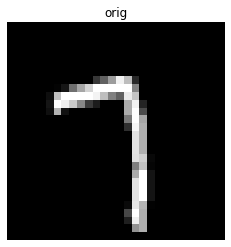

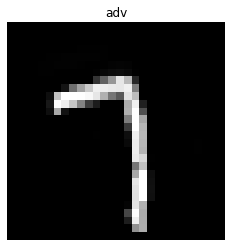

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 43.33%
  Sample:


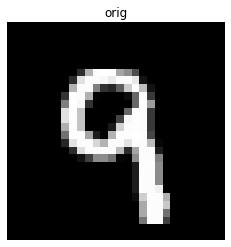

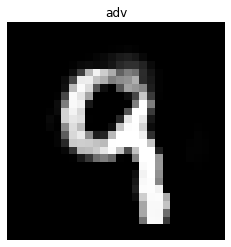

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


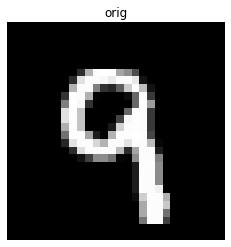

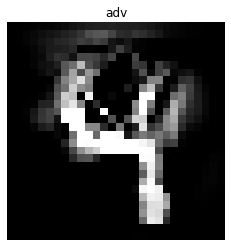

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
======== L2AdditiveGaussianNoiseAttack =======

 Epsilon: 0.3
  Robust accuracy 82.50%
  Sample:


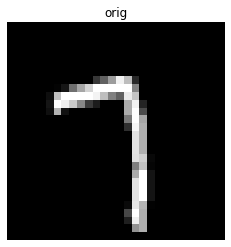

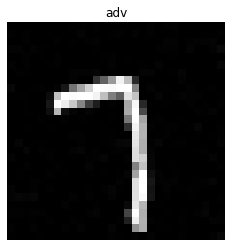

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 90.83%
  Sample:


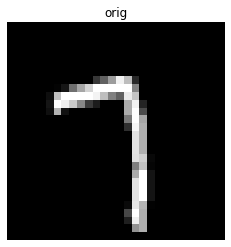

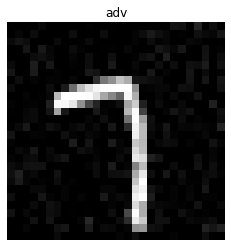

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 94.17%
  Sample:


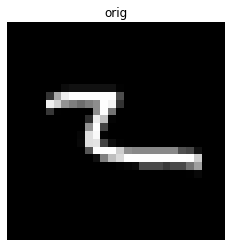

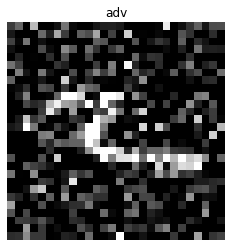

   Prediction for usual: 8
   Label: 2
   Prediction for adv.: 4
======== L2DeepFoolAttack =======

 Epsilon: 0.3
  Robust accuracy 80.00%
  Sample:


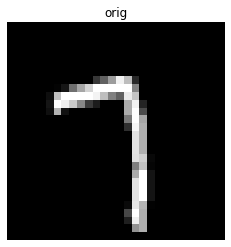

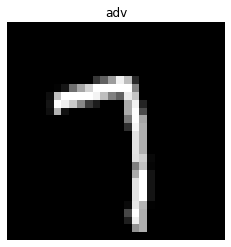

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 46.67%
  Sample:


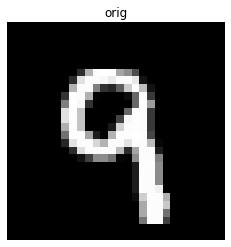

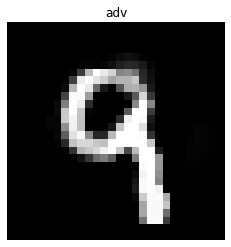

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 10.00%
  Sample:


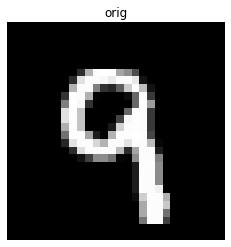

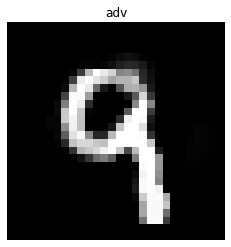

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
======== L2FastGradientAttack =======

 Epsilon: 0.3
  Robust accuracy 80.83%
  Sample:


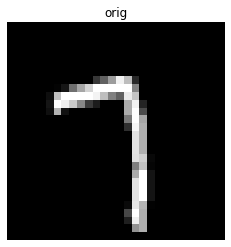

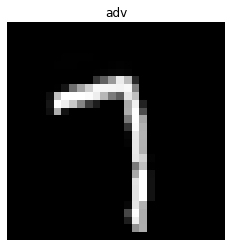

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 67.50%
  Sample:


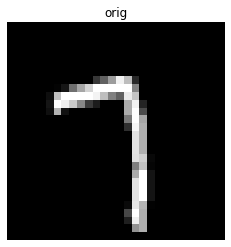

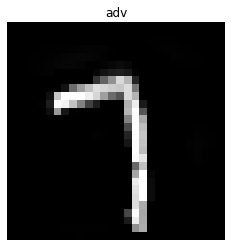

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 11.67%
  Sample:


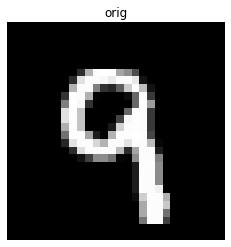

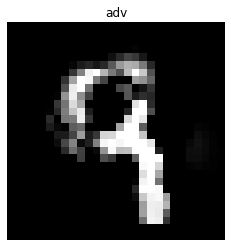

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
======== LinfFastGradientAttack =======

 Epsilon: 0.3
  Robust accuracy 18.33%
  Sample:


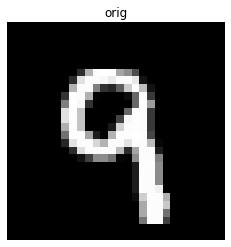

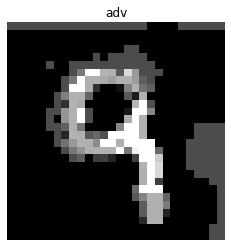

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 0.00%
  Sample:


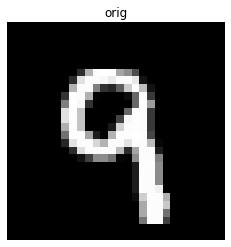

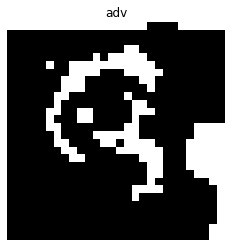

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 6
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


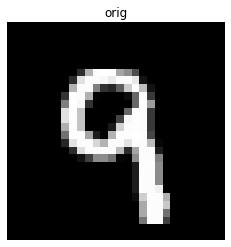

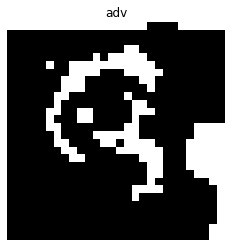

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 6
======== LinfProjectedGradientDescentAttack =======

 Epsilon: 0.3
  Robust accuracy 0.00%
  Sample:


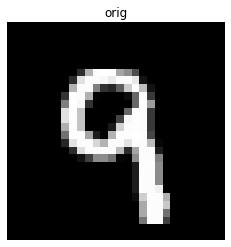

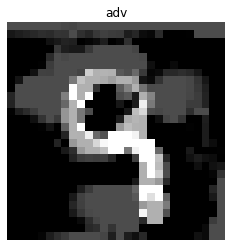

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
 Epsilon: 1.5
  Robust accuracy 0.00%
  Sample:


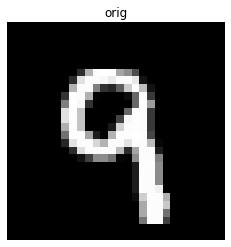

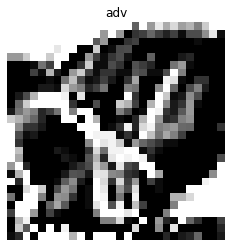

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


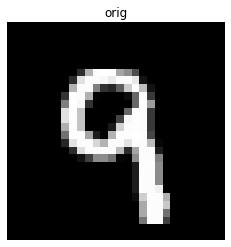

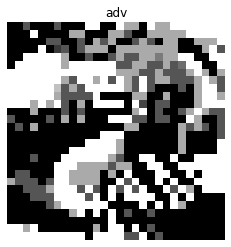

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 2
======== SaltAndPepperNoiseAttack =======

 Epsilon: 0.3
  Robust accuracy 82.50%
  Sample:


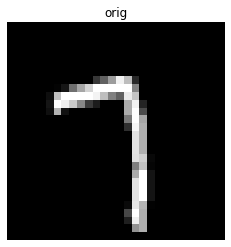

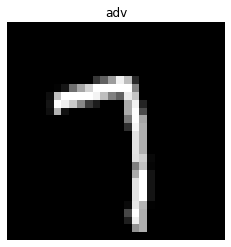

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 1.5
  Robust accuracy 79.17%
  Sample:


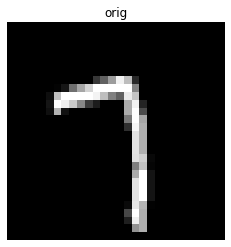

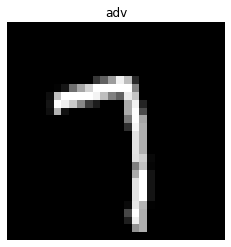

   Prediction for usual: 8
   Label: 7
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 26.67%
  Sample:


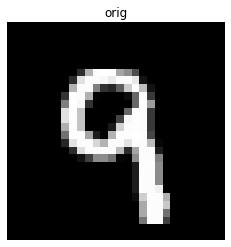

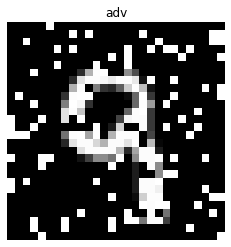

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 3
------
 Lambda=0.75 
 ------

epoch:  1

Test set: Average loss: 1.9423, Accuracy: 2167/10000 (22%)

epoch:  2

Test set: Average loss: 1.8315, Accuracy: 2389/10000 (24%)

epoch:  3

Test set: Average loss: 1.7269, Accuracy: 2491/10000 (25%)

epoch:  1

Test set: Average loss: 1.6717, Accuracy: 2816/10000 (28%)

epoch:  2

Test set: Average loss: 1.0821, Accuracy: 4116/10000 (41%)

epoch:  3

Test set: Average loss: 1.3699, Accuracy: 3875/10000 (39%)

epoch:  1

Test set: Average loss: 1.0538, Accuracy: 3767/10000 (38%)

epoch:  2

Test set: Average loss: 0.9742, Accuracy: 3907/10000 (39%)

epoch:  3

Test set: Average loss: 1.0651, Accuracy: 3879/10000 (39%)

AT Ensemble clean accuracy: 0.8666667342185974
======== L2BasicIterativeAttack =======

 Epsilon: 0.3
  Robust accuracy 81.67%
  Sample:


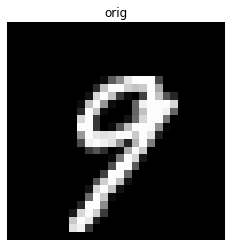

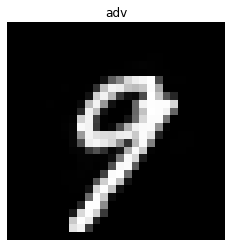

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 1.5
  Robust accuracy 41.67%
  Sample:


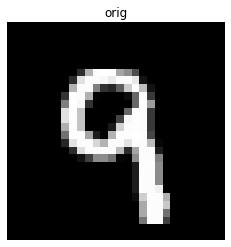

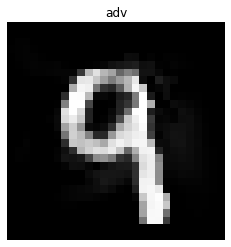

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


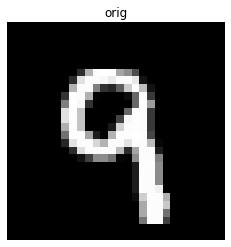

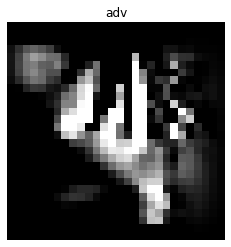

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
======== L2AdditiveGaussianNoiseAttack =======

 Epsilon: 0.3
  Robust accuracy 87.50%
  Sample:


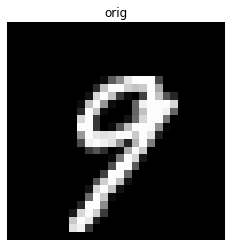

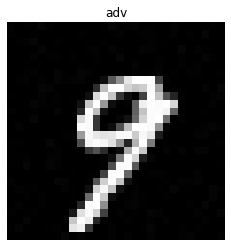

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 1.5
  Robust accuracy 89.17%
  Sample:


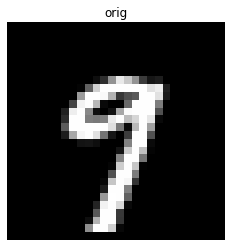

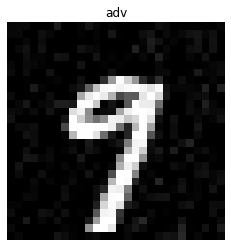

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 10
  Robust accuracy 80.83%
  Sample:


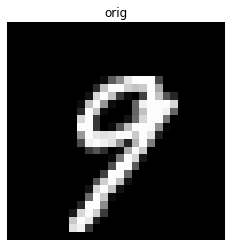

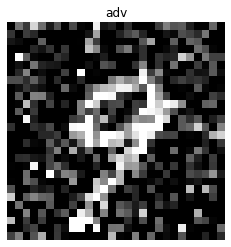

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 4
======== L2DeepFoolAttack =======

 Epsilon: 0.3
  Robust accuracy 79.17%
  Sample:


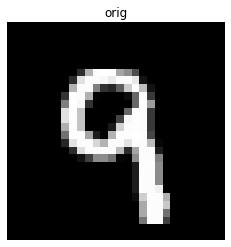

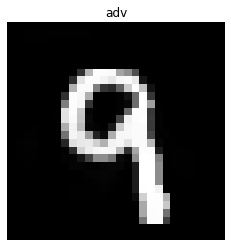

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 7
 Epsilon: 1.5
  Robust accuracy 38.33%
  Sample:


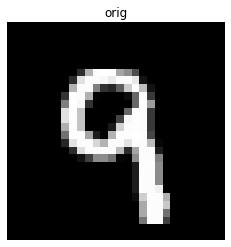

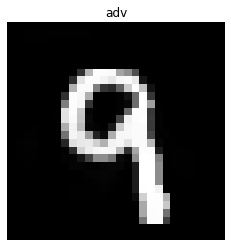

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 7
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


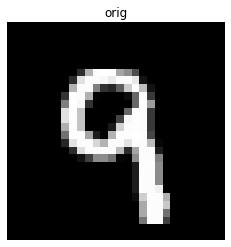

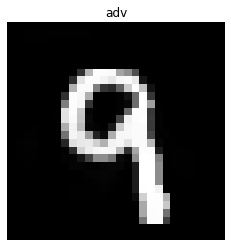

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 7
======== L2FastGradientAttack =======

 Epsilon: 0.3
  Robust accuracy 82.50%
  Sample:


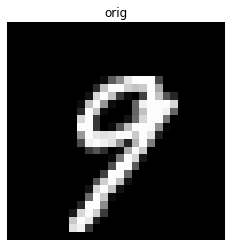

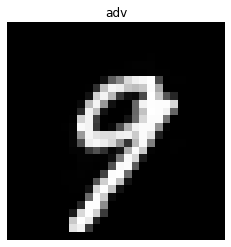

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 1.5
  Robust accuracy 57.50%
  Sample:


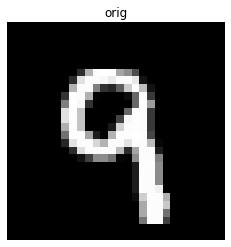

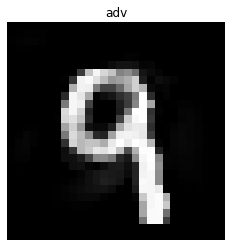

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
 Epsilon: 10
  Robust accuracy 0.83%
  Sample:


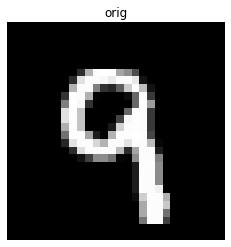

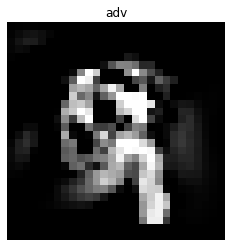

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 7
======== LinfFastGradientAttack =======

 Epsilon: 0.3
  Robust accuracy 0.00%
  Sample:


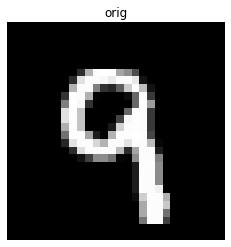

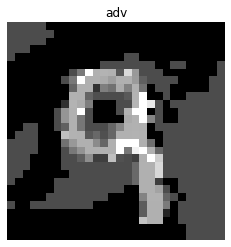

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 2
 Epsilon: 1.5
  Robust accuracy 0.00%
  Sample:


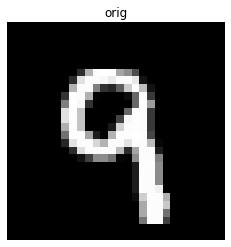

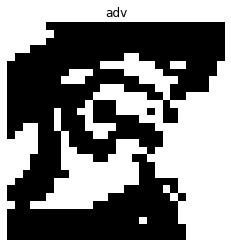

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 0
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


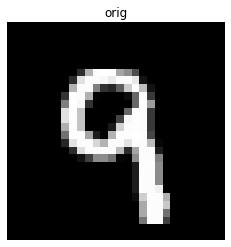

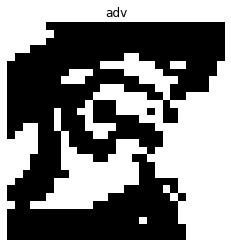

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 0
======== LinfProjectedGradientDescentAttack =======

 Epsilon: 0.3
  Robust accuracy 0.00%
  Sample:


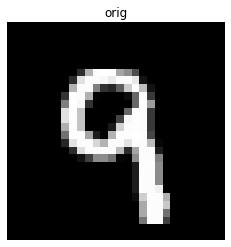

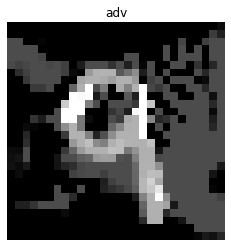

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 4
 Epsilon: 1.5
  Robust accuracy 0.00%
  Sample:


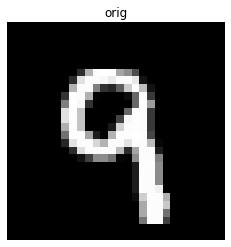

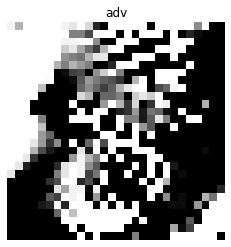

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
 Epsilon: 10
  Robust accuracy 0.00%
  Sample:


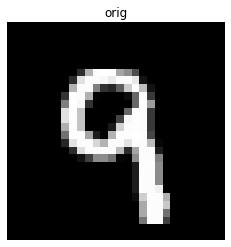

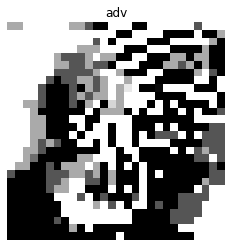

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 8
======== SaltAndPepperNoiseAttack =======

 Epsilon: 0.3
  Robust accuracy 85.83%
  Sample:


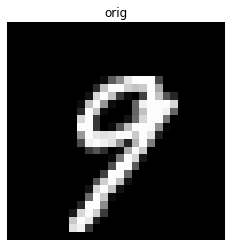

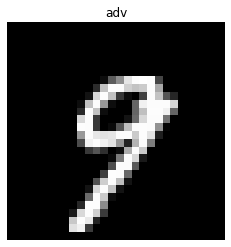

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 1.5
  Robust accuracy 82.50%
  Sample:


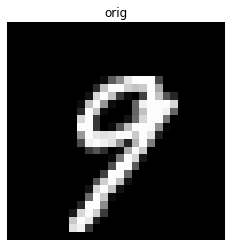

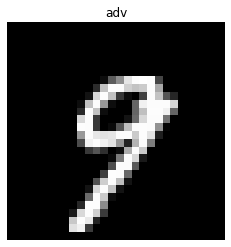

   Prediction for usual: 7
   Label: 9
   Prediction for adv.: 7
 Epsilon: 10
  Robust accuracy 26.67%
  Sample:


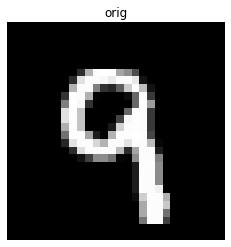

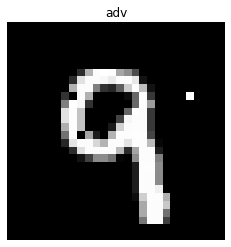

   Prediction for usual: 9
   Label: 9
   Prediction for adv.: 7


,AT Ensemble 0.2 3,AT Ensemble 0.75 3
"(L2BasicIterativeAttack, 0.3)",0.783333,0.816667
"(L2BasicIterativeAttack, 1.5)",0.433333,0.416667
"(L2BasicIterativeAttack, 10)",0.000000,0.000000
"(L2AdditiveGaussianNoiseAttack, 0.3)",0.825000,0.875000
"(L2AdditiveGaussianNoiseAttack, 1.5)",0.908333,0.891667
"(L2AdditiveGaussianNoiseAttack, 10)",0.941667,0.808333
"(L2DeepFoolAttack, 0.3)",0.800000,0.791667
"(L2DeepFoolAttack, 1.5)",0.466667,0.383333
"(L2DeepFoolAttack, 10)",0.100000,0.000000
"(L2FastGradientAttack, 0.3)",0.808333,0.825000


In [ ]:
import copy 
report = pd.DataFrame(index=index)
adv_train_subset, adv_val_subset, _ = torch.utils.data.random_split(
  mnist_train,
  [int(mnist_train_n * 1/12), int(mnist_train_n*1/12), int(mnist_train_n*10/12)],  # Adv. example generation is slow. So take a few.
  generator=torch.Generator().manual_seed(1)
)

adv_train_loader =  torch.utils.data.DataLoader(
  adv_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
adv_val_loader =  torch.utils.data.DataLoader(
  adv_val_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
epsilon = 1.5
at_epochs = 3
attack = fbattacks.LinfProjectedGradientDescentAttack()

for at_lambda in (0.2, 0.75):
  print(f"------\n Lambda={at_lambda} \n ------\n")

  for innerm in (model1, model2, model3): #, model4, model5):
    innermodelcopy = copy.deepcopy(innerm)
    mymodel = FBModel(innermodelcopy, bounds=(images.min().item(),images.max().item()), device='cuda')
    #mymodel = FBModel(innerm, bounds=(images.min().item(),images.max().item()), device='cuda')
    def adv_attack(images, labels):
      global mymodel
      _, clippedadv, _ = attack(
          mymodel,
          images,
          labels,
          epsilons=epsilon
      )
      return clippedadv
    train(
        adv_train_loader,
        adv_val_loader, 
        innerm, 
        num_epochs = at_epochs, 
        adversarial_attack=adv_attack, 
        adversarial_lambda=at_lambda
      )

  fmodel = FBModel(ensemble, bounds=(images.min().item(),images.max().item()), device='cuda')
  print(f'AT Ensemble clean accuracy: {fbutils.accuracy(fmodel, images, labels)}')
  ensemble_res = adv_attack_nn(fmodel, images, labels, verbose=True)
  report[f'AT Ensemble {at_lambda} {at_epochs}'] = pd.Series([e[2] for e in ensemble_res],index=index)
report


# Calibration

In [ ]:
bins_ints = list(e/10 for e in range(0, 10, 1))
bins_ints

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def calc_calibration(model):
  EPSILON = 0.0000001
  count = 0
  bins = {b : defaultdict(float) for b in bins_ints}
  for images, labels in train_loader:
    count += len(images)
    images = images.cuda()
    labels = labels.cuda()
    if labels.shape 
    predictions = model(images).softmax(axis=1)
    for ps, l in zip(predictions, labels):
      maxp = ps.max(axis=0)
      plabel, prob  = maxp.indices.item(), maxp.values.item()
      mybin = bins[int(prob * 10) / 10.0]
      mybin['psum'] += prob
      mybin['msum'] += float(l == plabel)
      mybin['count'] += 1.0
  for k in bins:
    b = bins[k]
    b['rms_error'] = (b['psum'] - b['msum'])**2 / (b['count'] + EPSILON)/ (count + EPSILON)
    b['accuracy'] = b['msum'] / (b['count'] + EPSILON)
    b['confidence'] = b['psum'] / (b['count'] + EPSILON)
    b['ece'] = abs(b['accuracy'] - b['confidence']) * b['count'] / (count + EPSILON)
    b['mce'] = abs(b['accuracy'] - b['confidence'])
  rms_error = sum(bins[k]['rms_error'] for k in bins)**.5  # TODO: See below results. Why not changed?
  ece = sum(bins[k]['ece'] for k in bins)
  mce = max(bins[k]['mce'] for k in bins)
  calcs = {
      'rms_error': rms_error,
      'ece': ece,
      'mce': mce,
      'bins': bins,
      'count': count
  }
  return calcs

def print_calibration_report(calcs):
  bins = calcs['bins']
  print(f"RMS error: {calcs['rms_error']}")
  print(f"ECE: {calcs['ece']}")
  print(f"MCE: {calcs['mce']}")
  r = pd.DataFrame(index=bins_ints)
  r['score'] = pd.Series([bins[k]['res'] for k in bins_ints], index=bins_ints)
  r['count'] = pd.Series([bins[k]['count'] for k in bins_ints], index=bins_ints)
  r['msum'] = pd.Series([bins[k]['msum'] for k in bins_ints], index=bins_ints)
  r['psum'] = pd.Series([bins[k]['psum'] for k in bins_ints], index=bins_ints)
  r['accuracy'] = pd.Series([bins[k]['accuracy'] for k in bins_ints], index=bins_ints)
  r.loc['Total'] = r.sum(numeric_only=True)
  def accuracybar(r):
    r = r.copy()
    r = r.drop('Total')
    index = bins_ints
    r2 = pd.DataFrame({
        'accuracy': r['accuracy'],
        'bins': bins_ints
      },
      index=bins_ints
    )
    r2.plot.bar()
    plt.show()
  def density(r):
    r = r.copy()
    r = r.drop('Total')
    index = bins_ints
    r2 = pd.DataFrame({
        '% of samples': r['count']/calcs['count'],
        'bins': bins_ints
      },
      index=bins_ints
    )
    r2.plot.bar()
    plt.show()
  accuracybar(r)
  density(r)


In [ ]:
index =['RMS', 'ECE', 'MCE']
calibration_report = pd.DataFrame(index=index)
def add_to_report(col, calcs):
  calibration_report[col] = pd.Series([calcs[k] for k in ('rms_error', 'ece', 'mce')], index=index)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RMS error: 0.11820861548272725
ECE: 0.10062015999484102
MCE: 0.1980684120586056


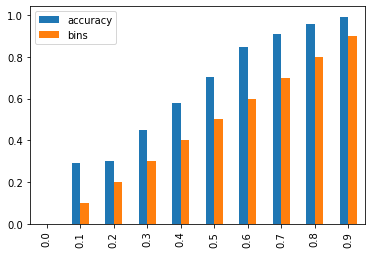

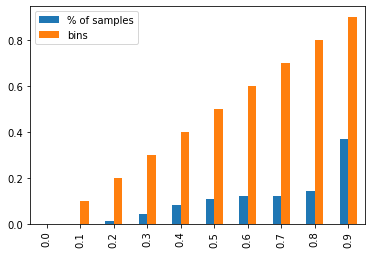

In [ ]:
calcs = calc_calibration(weakModel)
print_calibration_report(calcs)
add_to_report('CNN', calcs)


RMS error: 0.006872477579252087
ECE: 0.0068724775792383475
MCE: 0.006872477579252093


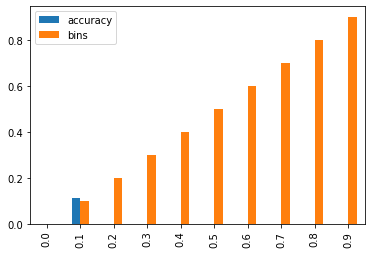

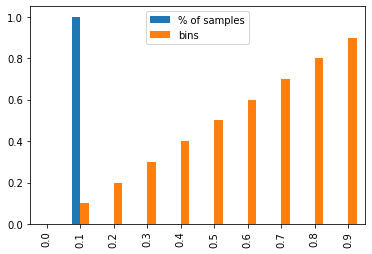

In [ ]:
calcs = calc_calibration(ensemble)
print_calibration_report(calcs)
add_to_report('Vanilla Ensemble', calcs)

In [ ]:

calcs = calc_calibration(ensemble5)
print_calibration_report(calcs)
add_to_report('Ensemble5', calcs)

NameError: ignored

In [ ]:
temperatura = [0.7, 0.8, 0.9, 1, 2, 3]

for temp in temperatura:
  ensemble = Ensemble([model1, model2, model3], temp)
  calcs = calc_calibration(ensemble)
  print("Eto temperatura: ", temp)
  print_calibration_report(calcs)
  add_to_report(f'Ensemble. T={temp}', calcs)

In [ ]:
temperatura = [3, 5, 10]

for temp in temperatura:
  ensemble = Ensemble([model1, model2, model3, model4, model5], temp)
  calcs = calc_calibration(ensemble)
  print("Eto temperatura: ", temp)
  print_calibration_report(calcs)
  add_to_report(f'Ens5. T={temp}', calcs)

In [ ]:
calibration_report

# Distribution shift


In [ ]:
!wget https://zenodo.org/record/3239543/files/mnist_c.zip
!unzip mnist_c.zip

--2022-08-27 04:37:15--  https://zenodo.org/record/3239543/files/mnist_c.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246661575 (235M) [application/octet-stream]
Saving to: ‘mnist_c.zip’

mnist_c.zip         100%[===================>] 235.23M  9.52MB/s    in 47s     

2022-08-27 04:38:03 (5.04 MB/s) - ‘mnist_c.zip’ saved [246661575/246661575]

Archive:  mnist_c.zip
   creating: mnist_c/
   creating: mnist_c/impulse_noise/
  inflating: mnist_c/impulse_noise/test_images.npy  
  inflating: mnist_c/impulse_noise/train_images.npy  
  inflating: mnist_c/impulse_noise/test_labels.npy  
  inflating: mnist_c/impulse_noise/train_labels.npy  
   creating: mnist_c/canny_edges/
  inflating: mnist_c/canny_edges/test_images.npy  
  inflating: mnist_c/canny_edges/train_images.npy  
  inflating: mnist_c/canny_edges/test_labels.npy  
  inflating: mnist_c/canny_edges/tra

In [ ]:
brightness_train_data = np.load("/content/mnist_c/brightness/train_images.npy")
brightness_train_labels = np.load("/content/mnist_c/brightness/train_labels.npy")
 
canny_train_data = np.load("/content/mnist_c/canny_edges/train_images.npy")
canny_train_labels = np.load("/content/mnist_c/canny_edges/train_labels.npy")
 
dotted_line_train_data = np.load("/content/mnist_c/dotted_line/train_images.npy")
dotted_line_train_labels = np.load("/content/mnist_c/dotted_line/train_labels.npy")
 
fog_train_data = np.load("/content/mnist_c/fog/train_images.npy")
fog_train_labels = np.load("/content/mnist_c/fog/train_labels.npy")
 
glass_blur_train_data = np.load("/content/mnist_c/glass_blur/train_images.npy")
glass_blur_train_labels = np.load("/content/mnist_c/glass_blur/train_labels.npy")
 
identity_train_data = np.load("/content/mnist_c/identity/train_images.npy")
identity_train_labels = np.load("/content/mnist_c/identity/train_labels.npy")
 
impulse_noise_train_data = np.load("/content/mnist_c/impulse_noise/train_images.npy")
impulse_noise_train_labels = np.load("/content/mnist_c/impulse_noise/train_labels.npy")

In [ ]:
brightness_test_data = np.load("/content/mnist_c/brightness/test_images.npy")
brightness_test_labels = np.load("/content/mnist_c/brightness/test_labels.npy")

canny_test_data = np.load("/content/mnist_c/canny_edges/test_images.npy")
canny_test_labels = np.load("/content/mnist_c/canny_edges/test_labels.npy")

dotted_line_test_data = np.load("/content/mnist_c/dotted_line/test_images.npy")
dotted_line_test_labels = np.load("/content/mnist_c/dotted_line/test_labels.npy")

fog_test_data = np.load("/content/mnist_c/fog/test_images.npy")
fog_test_labels = np.load("/content/mnist_c/fog/test_labels.npy")

glass_blur_test_data = np.load("/content/mnist_c/glass_blur/test_images.npy")
glass_blur_test_labels = np.load("/content/mnist_c/glass_blur/test_labels.npy")

identity_test_data = np.load("/content/mnist_c/identity/test_images.npy")
identity_test_labels = np.load("/content/mnist_c/identity/test_labels.npy")

impulse_noise_test_data = np.load("/content/mnist_c/impulse_noise/test_images.npy")
impulse_noise_test_labels = np.load("/content/mnist_c/impulse_noise/test_labels.npy")


In [ ]:
brightness_train_data = torch.from_numpy(brightness_train_data).cuda()
brightness_train_labels = torch.from_numpy(brightness_train_labels).cuda()
 
canny_train_data = torch.from_numpy(canny_train_data).cuda()
canny_train_labels = torch.from_numpy(canny_train_labels).cuda()
 
dotted_line_train_data = torch.from_numpy(dotted_line_train_data).cuda()
dotted_line_train_labels = torch.from_numpy(dotted_line_train_labels).cuda()
 
fog_train_data = torch.from_numpy(fog_train_data).cuda()
fog_train_labels = torch.from_numpy(fog_train_labels).cuda()
 
glass_blur_train_data = torch.from_numpy(glass_blur_train_data).cuda()
glass_blur_train_labels = torch.from_numpy(glass_blur_train_labels).cuda()
 
identity_train_data = torch.from_numpy(identity_train_data).cuda()
identity_train_labels = torch.from_numpy(identity_train_labels).cuda()
 
impulse_noise_train_data = torch.from_numpy(impulse_noise_train_data).cuda()
impulse_noise_train_labels = torch.from_numpy(impulse_noise_train_labels).cuda()

In [ ]:
brightness_test_data = torch.from_numpy(brightness_test_data).cuda()
brightness_test_labels = torch.from_numpy(brightness_test_labels).cuda()

canny_test_data = torch.from_numpy(canny_test_data).cuda()
canny_test_labels = torch.from_numpy(canny_test_labels).cuda()

dotted_line_test_data = torch.from_numpy(dotted_line_test_data).cuda()
dotted_line_test_labels = torch.from_numpy(dotted_line_test_labels).cuda()

fog_test_data = torch.from_numpy(fog_test_data).cuda()
fog_test_labels = torch.from_numpy(fog_test_labels).cuda()

glass_blur_test_data = torch.from_numpy(glass_blur_test_data).cuda()
glass_blur_test_labels = torch.from_numpy(glass_blur_test_labels).cuda()

identity_test_data = torch.from_numpy(identity_test_data).cuda()
identity_test_labels = torch.from_numpy(identity_test_labels).cuda()

impulse_noise_test_data = torch.from_numpy(impulse_noise_test_data).cuda()
impulse_noise_test_labels = torch.from_numpy(impulse_noise_test_labels).cuda()

In [ ]:
brightness_train_labels = torch.nn.functional.one_hot(brightness_train_labels)
canny_train_labels = torch.nn.functional.one_hot(canny_train_labels)
dotted_line_train_labels = torch.nn.functional.one_hot(dotted_line_train_labels)
fog_train_labels = torch.nn.functional.one_hot(fog_train_labels)
glass_blur_train_labels = torch.nn.functional.one_hot(glass_blur_train_labels)
identity_train_labels = torch.nn.functional.one_hot(identity_train_labels)
impulse_noise_train_labels = torch.nn.functional.one_hot(impulse_noise_train_labels)

In [ ]:
brightness_test_labels = torch.nn.functional.one_hot(brightness_test_labels)
canny_test_labels = torch.nn.functional.one_hot(canny_test_labels)
dotted_line_test_labels = torch.nn.functional.one_hot(dotted_line_test_labels)
fog_test_labels = torch.nn.functional.one_hot(fog_test_labels)
glass_blur_test_labels = torch.nn.functional.one_hot(glass_blur_test_labels)
identity_test_labels = torch.nn.functional.one_hot(identity_test_labels)
impulse_noise_test_labels = torch.nn.functional.one_hot(impulse_noise_test_labels)

In [ ]:
def convert_to_shape(data, labels):
  new_structure = []
  for i in range(len(data)):
    instance = data[0].squeeze(2).unsqueeze(0)
    new_structure.append((instance, labels[i]))
  return new_structure

In [ ]:
brightness_train = convert_to_shape(brightness_train_data, brightness_train_labels)
canny_train = convert_to_shape(canny_train_data, canny_train_labels)
dotted_line_train =convert_to_shape(dotted_line_train_data, dotted_line_train_labels)
fog_train =convert_to_shape(fog_train_data, fog_train_labels)
glass_blur_train =convert_to_shape(glass_blur_train_data, glass_blur_train_labels)
identity_train =convert_to_shape(identity_train_data, identity_train_labels)
impulse_noise_train =convert_to_shape(impulse_noise_train_data, impulse_noise_train_labels)

In [ ]:
brightness_test = convert_to_shape(brightness_test_data, brightness_test_labels)
canny_test = convert_to_shape(canny_test_data, canny_test_labels)
dotted_line_test =convert_to_shape(dotted_line_test_data, dotted_line_test_labels)
fog_test =convert_to_shape(fog_test_data, fog_test_labels)
glass_blur =convert_to_shape(glass_blur_test_data, glass_blur_test_labels)
identity_test =convert_to_shape(identity_test_data, identity_test_labels)
impulse_noise_test =convert_to_shape(impulse_noise_test_data, impulse_noise_test_labels)

In [ ]:
brightness_train_subset, brightness_val_subset = torch.utils.data.random_split(
  brightness_train,
  [int(len(brightness_train) * 5/6), int(len(brightness_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

canny_train_subset, canny_val_subset = torch.utils.data.random_split(
  canny_train,
  [int(len(canny_train) * 5/6), int(len(canny_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

dotted_line_train_subset, dotted_line_val_subset = torch.utils.data.random_split(
  dotted_line_train,
  [int(len(dotted_line_train) * 5/6), int(len(dotted_line_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

fog_train_subset, fog_val_subset = torch.utils.data.random_split(
  fog_train,
  [int(len(fog_train) * 5/6), int(len(fog_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

glass_blur_train_subset, glass_blur_val_subset = torch.utils.data.random_split(
  glass_blur_train,
  [int(len(glass_blur_train) * 5/6), int(len(glass_blur_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

identity_train_subset, identity_val_subset = torch.utils.data.random_split(
  identity_train,
  [int(len(identity_train) * 5/6), int(len(identity_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)

impulse_noise_train_subset, impulse_noise_val_subset = torch.utils.data.random_split(
  impulse_noise_train,
  [int(len(impulse_noise_train) * 5/6), int(len(impulse_noise_train) * 1/6)],
  generator=torch.Generator().manual_seed(1)
)



In [ ]:
brightness_loader = torch.utils.data.DataLoader(
  brightness_train_subset,
  batch_size = args['batch_size_outlier'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
brightness_val_loader = torch.utils.data.DataLoader(
  brightness_val_subset,
  batch_size = args['batch_size_ood'], 
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
brightness_test_loader = torch.utils.data.DataLoader(
  brightness_test,
  batch_size = args['batch_size_ood'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)


Noise training

In [ ]:
mnist_train_noise_10
mnist_train_noise_10_n = len(mnist_train_noise_10)
print('mnist_train_noise_15_n', mnist_train_noise_10_n)
noise_10_train_subset, noise_10_val_subset = torch.utils.data.random_split(
  mnist_train_noise_10,
  [int(math.floor(mnist_train_noise_10_n * 5/6)), int(math.ceil(mnist_train_noise_10_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
noise_10_train_loader = torch.utils.data.DataLoader(
  noise_10_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
noise_10_val_loader = torch.utils.data.DataLoader(
  noise_10_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

mnist_train_noise_15_n 65703


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mnist_train_noise_15
mnist_train_noise_15_n = len(mnist_train_noise_15)
print('mnist_train_noise_15_n', mnist_train_noise_15_n)
noise_15_train_subset, noise_15_val_subset = torch.utils.data.random_split(
  mnist_train_noise_15,
  [int(math.floor(mnist_train_noise_15_n * 5/6)), int(math.ceil(mnist_train_noise_15_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
noise_15_train_loader = torch.utils.data.DataLoader(
  noise_15_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
noise_15_val_loader = torch.utils.data.DataLoader(
  noise_15_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_noise_15_n 68324


In [ ]:
mnist_train_noise_20
mnist_train_noise_20_n = len(mnist_train_noise_20)
print('mnist_train_noise_20_n', mnist_train_noise_20_n)
noise_20_train_subset, noise_20_val_subset = torch.utils.data.random_split(
  mnist_train_noise_20,
  [int(math.floor(mnist_train_noise_20_n * 5/6)), int(math.ceil(mnist_train_noise_20_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)

noise_20_train_loader = torch.utils.data.DataLoader(
  noise_20_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

noise_20_val_loader = torch.utils.data.DataLoader(
  noise_20_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)

mnist_train_noise_20_n 70860


In [ ]:
mnist_train_noise_25
mnist_train_noise_25_n = len(mnist_train_noise_25)
print('mnist_train_noise_25_n', mnist_train_noise_25_n)
noise_25_train_subset, noise_25_val_subset = torch.utils.data.random_split(
  mnist_train_noise_25,
  [int(math.floor(mnist_train_noise_25_n * 5/6)), int(math.ceil(mnist_train_noise_25_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
noise_25_train_loader = torch.utils.data.DataLoader(
  noise_25_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
noise_25_val_loader = torch.utils.data.DataLoader(
  noise_25_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_noise_25_n 73291


In [ ]:
mnist_train_noise_30
mnist_train_noise_30_n = len(mnist_train_noise_30)
print('mnist_train_noise_30_n', mnist_train_noise_30_n)
noise_30_train_subset, noise_30_val_subset = torch.utils.data.random_split(
  mnist_train_noise_30,
  [int(math.floor(mnist_train_noise_30_n * 5/6)), int(math.ceil(mnist_train_noise_30_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
noise_30_train_loader = torch.utils.data.DataLoader(
  noise_30_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
noise_30_val_loader = torch.utils.data.DataLoader(
  noise_30_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_noise_30_n 75495


In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_10_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_10_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_10_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_10_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_10_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3556, Accuracy: 9915/10000 (99%)

epoch:  1

Test set: Average loss: 0.3595, Accuracy: 9917/10000 (99%)

epoch:  1

Test set: Average loss: 0.3655, Accuracy: 9916/10000 (99%)

epoch:  1

Test set: Average loss: 0.4470, Accuracy: 9850/10000 (98%)

epoch:  1

Test set: Average loss: 0.4108, Accuracy: 9895/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3568, Accuracy: 9932/10000 (99%)


Test set: Average loss: 0.3783, Accuracy: 9923/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_15_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3617, Accuracy: 9905/10000 (99%)

epoch:  1

Test set: Average loss: 0.3601, Accuracy: 9925/10000 (99%)

epoch:  1

Test set: Average loss: 0.3666, Accuracy: 9916/10000 (99%)

epoch:  1

Test set: Average loss: 0.4522, Accuracy: 9845/10000 (98%)

epoch:  1

Test set: Average loss: 0.4087, Accuracy: 9890/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3594, Accuracy: 9917/10000 (99%)


Test set: Average loss: 0.3803, Accuracy: 9919/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_20_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3611, Accuracy: 9912/10000 (99%)

epoch:  1

Test set: Average loss: 0.3539, Accuracy: 9924/10000 (99%)

epoch:  1

Test set: Average loss: 0.3509, Accuracy: 9909/10000 (99%)

epoch:  1

Test set: Average loss: 0.4430, Accuracy: 9846/10000 (98%)

epoch:  1

Test set: Average loss: 0.4118, Accuracy: 9888/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3501, Accuracy: 9925/10000 (99%)


Test set: Average loss: 0.3730, Accuracy: 9924/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_25_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3609, Accuracy: 9911/10000 (99%)

epoch:  1

Test set: Average loss: 0.3673, Accuracy: 9918/10000 (99%)

epoch:  1

Test set: Average loss: 0.3613, Accuracy: 9904/10000 (99%)

epoch:  1

Test set: Average loss: 0.4542, Accuracy: 9845/10000 (98%)

epoch:  1

Test set: Average loss: 0.4091, Accuracy: 9897/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3597, Accuracy: 9920/10000 (99%)


Test set: Average loss: 0.3813, Accuracy: 9916/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_30_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3605, Accuracy: 9900/10000 (99%)

epoch:  1

Test set: Average loss: 0.3623, Accuracy: 9916/10000 (99%)

epoch:  1

Test set: Average loss: 0.3622, Accuracy: 9907/10000 (99%)

epoch:  1

Test set: Average loss: 0.4573, Accuracy: 9842/10000 (98%)

epoch:  1

Test set: Average loss: 0.4086, Accuracy: 9896/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3580, Accuracy: 9918/10000 (99%)


Test set: Average loss: 0.3805, Accuracy: 9919/10000 (99%)



MixUp Training

In [ ]:
mnist_train_mixup_10
mnist_train_mixup_10_n = len(mnist_train_mixup_10)
print('mnist_train_mixup_15_n', mnist_train_mixup_10_n)
mixup_10_train_subset, mixup_10_val_subset = torch.utils.data.random_split(
  mnist_train_mixup_10,
  [int(math.floor(mnist_train_mixup_10_n * 5/6)), int(math.ceil(mnist_train_mixup_10_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
mixup_10_train_loader = torch.utils.data.DataLoader(
  mixup_10_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
mixup_10_val_loader = torch.utils.data.DataLoader(
  mixup_10_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_mixup_15_n 65725


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
mnist_train_mixup_15
mnist_train_mixup_15_n = len(mnist_train_mixup_15)
print('mnist_train_mixup_15_n', mnist_train_mixup_15_n)
mixup_15_train_subset, mixup_15_val_subset = torch.utils.data.random_split(
  mnist_train_mixup_15,
  [int(math.floor(mnist_train_mixup_15_n * 5/6)), int(math.ceil(mnist_train_mixup_15_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
mixup_15_train_loader = torch.utils.data.DataLoader(
  mixup_15_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
mixup_15_val_loader = torch.utils.data.DataLoader(
  mixup_15_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_mixup_15_n 68345


In [ ]:
mnist_train_mixup_20
mnist_train_mixup_20_n = len(mnist_train_mixup_20)
print('mnist_train_mixup_20_n', mnist_train_mixup_20_n)
mixup_20_train_subset, mixup_20_val_subset = torch.utils.data.random_split(
  mnist_train_mixup_20,
  [int(math.floor(mnist_train_mixup_20_n * 5/6)), int(math.ceil(mnist_train_mixup_20_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
mixup_20_train_loader = torch.utils.data.DataLoader(
  mixup_20_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
mixup_20_val_loader = torch.utils.data.DataLoader(
  mixup_20_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_mixup_20_n 70892


In [ ]:
mnist_train_mixup_25
mnist_train_mixup_25_n = len(mnist_train_mixup_25)
print('mnist_train_mixup_25_n', mnist_train_mixup_25_n)
mixup_25_train_subset, mixup_25_val_subset = torch.utils.data.random_split(
  mnist_train_mixup_25,
  [int(math.floor(mnist_train_mixup_25_n * 5/6)), int(math.ceil(mnist_train_mixup_25_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
mixup_25_train_loader = torch.utils.data.DataLoader(
  mixup_25_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
mixup_25_val_loader = torch.utils.data.DataLoader(
  mixup_25_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_mixup_25_n 73301


In [ ]:
mnist_train_mixup_30
mnist_train_mixup_30_n = len(mnist_train_mixup_30)
print('mnist_train_mixup_30_n', mnist_train_mixup_30_n)
mixup_30_train_subset, mixup_30_val_subset = torch.utils.data.random_split(
  mnist_train_mixup_30,
  [int(math.floor(mnist_train_mixup_30_n * 5/6)), int(math.ceil(mnist_train_mixup_30_n*1/6))],
  generator=torch.Generator().manual_seed(1)
)
 
mixup_30_train_loader = torch.utils.data.DataLoader(
  mixup_30_train_subset,
  batch_size = args['batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)
 
mixup_30_val_loader = torch.utils.data.DataLoader(
  mixup_30_val_subset,
  batch_size = args['test_batch_size_conv'],
  shuffle = True,
  num_workers = args['num_workers'],
  **kwargs
)



mnist_train_mixup_30_n 75596


In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(mixup_10_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(mixup_10_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(mixup_10_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(mixup_10_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(mixup_10_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3568, Accuracy: 9932/10000 (99%)


Test set: Average loss: 0.3783, Accuracy: 9923/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_15_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_15_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3617, Accuracy: 9905/10000 (99%)

epoch:  1

Test set: Average loss: 0.3601, Accuracy: 9925/10000 (99%)

epoch:  1

Test set: Average loss: 0.3666, Accuracy: 9916/10000 (99%)

epoch:  1

Test set: Average loss: 0.4522, Accuracy: 9845/10000 (98%)

epoch:  1

Test set: Average loss: 0.4087, Accuracy: 9890/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3594, Accuracy: 9917/10000 (99%)


Test set: Average loss: 0.3803, Accuracy: 9919/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_20_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_20_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3611, Accuracy: 9912/10000 (99%)

epoch:  1

Test set: Average loss: 0.3539, Accuracy: 9924/10000 (99%)

epoch:  1

Test set: Average loss: 0.3509, Accuracy: 9909/10000 (99%)

epoch:  1

Test set: Average loss: 0.4430, Accuracy: 9846/10000 (98%)

epoch:  1

Test set: Average loss: 0.4118, Accuracy: 9888/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3501, Accuracy: 9925/10000 (99%)


Test set: Average loss: 0.3730, Accuracy: 9924/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_25_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_25_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3609, Accuracy: 9911/10000 (99%)

epoch:  1

Test set: Average loss: 0.3673, Accuracy: 9918/10000 (99%)

epoch:  1

Test set: Average loss: 0.3613, Accuracy: 9904/10000 (99%)

epoch:  1

Test set: Average loss: 0.4542, Accuracy: 9845/10000 (98%)

epoch:  1

Test set: Average loss: 0.4091, Accuracy: 9897/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3597, Accuracy: 9920/10000 (99%)


Test set: Average loss: 0.3813, Accuracy: 9916/10000 (99%)



In [ ]:
model1 = conv3()
model2 = conv5()
model3 = conv7()
model4 = conv3_()
model5 = conv5_()

if args['cuda']:
    model1.cuda()
    model2.cuda()
    model3.cuda()
    model4.cuda()
    model5.cuda()

train(noise_30_train_loader, val_loader, model1, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model2, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model3, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model4, num_epochs = args['ensemble_epochs'])
train(noise_30_train_loader, val_loader, model5, num_epochs = args['ensemble_epochs'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


epoch:  1

Test set: Average loss: 0.3605, Accuracy: 9900/10000 (99%)

epoch:  1

Test set: Average loss: 0.3623, Accuracy: 9916/10000 (99%)

epoch:  1

Test set: Average loss: 0.3622, Accuracy: 9907/10000 (99%)

epoch:  1

Test set: Average loss: 0.4573, Accuracy: 9842/10000 (98%)

epoch:  1

Test set: Average loss: 0.4086, Accuracy: 9896/10000 (99%)



In [ ]:
ensemble = Ensemble([model1, model2, model3], 3)

test(ensemble, val_loader)

ensemble_5 = Ensemble([model1, model2, model3, model4, model5], 5)

test(ensemble_5, val_loader)


Test set: Average loss: 0.3580, Accuracy: 9918/10000 (99%)


Test set: Average loss: 0.3805, Accuracy: 9919/10000 (99%)

